# Centralizing the Data Vizualizations from the Paper

In [251]:
# dependencies
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model

sns.set_style("whitegrid")
sns.set()
%matplotlib inline

params = {'legend.fontsize': 'small',
          'figure.figsize': (10, 8),
         'axes.labelsize': 'small',
         'axes.titlesize':'small',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
plt.rcParams.update(params)


import importlib

In [252]:
# Loading mapping dictionaries from mapping_dictionaries notebook
%store -r df_ei
%store -r dic_re
%store -r dic_pur
%store -r dic_fuel

# convert a dictionary to a defaultdict
dic_re = defaultdict(lambda: 'Other',dic_re)
dic_pur = defaultdict(lambda: 'Other',dic_pur)
dic_fuel = defaultdict(lambda: 'Other',dic_fuel)

In [253]:
year = None
month = None
program = "prepilot"
study_type = "program"
mode_of_interest = "pilot_ebike"

## full data - for labeling rates

In [254]:
#gather all of the trips into one dataframe
#loop over
programs = ['4c', 'cc', 'fc', 'pc', 'sc', 'vail_22']
datasets = []

for program in programs:
    print('starting with ', program)
    
    #create dataset with surveys and trips
    trips = pd.read_csv('../Data/abby_ceo/' + program + '/analysis_confirmed_trip.csv')
    print(len(trips), 'trips')
    print(trips.perno.nunique(), 'people')

    #prepare trip ids for merging
    trips['user_id_socio'] = trips.perno.astype(str)
    trips['user_id_socio'] = trips['user_id_socio'].str.strip() #remove leading or trailing whitespace!!
    trips.user_id_socio = [i.replace('-','') for i in trips.user_id_socio] # remove all dashes from strings
    
    trips['program'] = program.split('_')[0]
    
    #add to list of datasets
    datasets.append(trips)

participant_ct_df = pd.concat(datasets)

#just labeled data
data = participant_ct_df[participant_ct_df.data_user_input_mode_confirm.notna() | 
                                       participant_ct_df.data_user_input_purpose_confirm.notna() |
                                       participant_ct_df.data_user_input_replaced_mode.notna()]

starting with  4c
14424 trips
15 people
starting with  cc
75199 trips
52 people
starting with  fc
32442 trips
30 people
starting with  pc
51196 trips
39 people
starting with  sc
17989 trips
22 people
starting with  vail_22
9133 trips
12 people


In [255]:
all_user_trips = participant_ct_df.groupby(['user_id_socio'], as_index=False).count()[['user_id_socio','data_distance']]
print(len(all_user_trips))
# print(labeled_user_trips.program.unique())

labeled_user_trips = data.groupby(['user_id_socio'], as_index=False).count()[['user_id_socio','data_distance']]
print(len(labeled_user_trips))
# print(labeled_user_trips.program.unique())

plot_data = all_user_trips.merge(labeled_user_trips, how='right', on='user_id_socio').fillna(0)
plot_data.head()

170
164


user_id_socio  data_distance_x  data_distance_y
0  0154d71439284c34b865e5a417cd48af             2104              276
1  03a395b4d8614757bb8432b4984559b0             1625              263
2  0958519bb4a64498b824015917eec592               18               17
3  0b3e78fa91d84aa6a3203440143c8c16             2430             2315
4  0d0ae3a556414d138c52a6040a203d24             1060                2

### figure 2

164


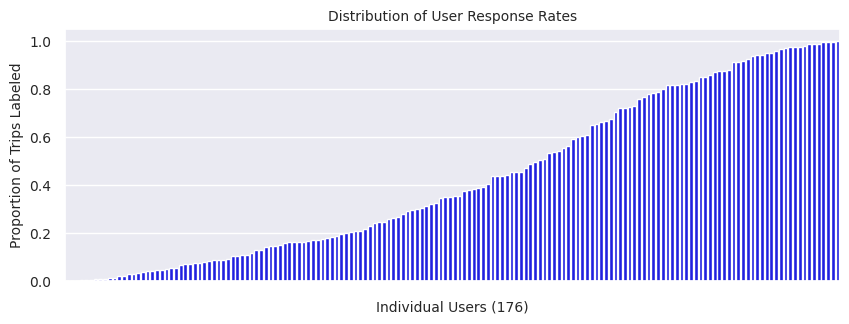

In [256]:
plot_data['proportion'] = plot_data['data_distance_y'] / plot_data['data_distance_x']
data_order = plot_data.sort_values('proportion', ascending=True).user_id_socio
print(len(plot_data))

plot_title='Distribution of User Response Rates'
ylab='Proportion of Trips Labeled'
file_name='CanBikeCO_report_user_participation%s'
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(data=plot_data, x='user_id_socio', y='proportion', order=data_order, color='blue').set(title=plot_title,xlabel='Individual Users (176)',ylabel=ylab,xticklabels=[])
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(file_name+".jpg", bbox_inches='tight')

In [257]:
labeled_user_trips.columns

Index(['user_id_socio', 'data_distance'], dtype='object')

In [258]:
#drop infected data
all_data = participant_ct_df.copy()

all_data['data_start_local_dt_month'] = all_data['data_start_local_dt_month'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).dropna()
all_data = all_data[all_data.data_start_local_dt_month >= 1]
all_data = all_data[all_data.data_start_local_dt_month <= 12]

all_data['data_start_local_dt_year'] = all_data['data_start_local_dt_year'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).dropna()
all_data = all_data[all_data.data_start_local_dt_year >= 2019]
all_data = all_data[all_data.data_start_local_dt_year <= 2023]

labeled = data.copy()
labeled['data_start_local_dt_month'] = labeled['data_start_local_dt_month'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).dropna()
labeled = labeled[labeled.data_start_local_dt_month >= 1]
labeled = labeled[labeled.data_start_local_dt_month <= 12]

labeled['data_start_local_dt_year'] = labeled['data_start_local_dt_year'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).dropna()
labeled = labeled[labeled.data_start_local_dt_year >= 2019]
labeled = labeled[labeled.data_start_local_dt_year <= 2023]

In [259]:
#group the total data by day
all_data = (all_data.groupby(['data_start_local_dt_month', 'data_start_local_dt_year']).size() 
   .reset_index(name='count'))

all_data = all_data.sort_values(['data_start_local_dt_year', 'data_start_local_dt_month'])

all_data = all_data.astype({'data_start_local_dt_month': 'str'})
all_data = all_data.astype({'data_start_local_dt_year': 'str'})
all_data['Month'] = all_data[['data_start_local_dt_year', 'data_start_local_dt_month']].agg('-'.join, axis=1)

#group the labeled data by day#group the total data by day
labeled = (labeled.groupby(['data_start_local_dt_month', 'data_start_local_dt_year']).size() 
   .reset_index(name='count'))

labeled = labeled.sort_values(['data_start_local_dt_year', 'data_start_local_dt_month'])

labeled = labeled.astype({'data_start_local_dt_month': 'str'})
labeled = labeled.astype({'data_start_local_dt_year': 'str'})
labeled['Month'] = labeled[['data_start_local_dt_year', 'data_start_local_dt_month']].agg('-'.join, axis=1)

#merge them
plot_data = all_data.merge(labeled, how='left', on='Month').fillna(0)

#calc the proportion
plot_data['proportion'] = plot_data['count_y'] / plot_data['count_x']

#drop data before 6/2022 (when the full pilot started)
plot_data = plot_data.iloc[5:]

### figure 3

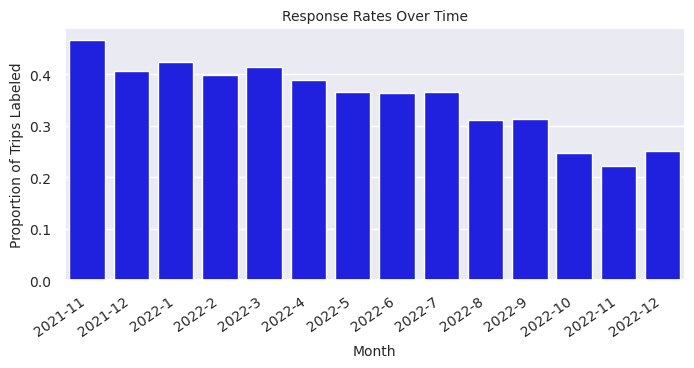

In [260]:
#graph it - bar chart

plot_title='Response Rates Over Time'
ylab='Proportion of Trips Labeled'
file_name='CanBikeCO_report_ts_labels'
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=plot_data, x='Month', y='proportion', color='blue').set(title=plot_title,xlabel='Month',ylabel=ylab)
plt.xticks(rotation=35, ha='right', fontsize=10)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(file_name+".jpeg", bbox_inches='tight')

## Loading from CSV way

In [261]:
# loading the data
data = pd.read_csv("../Data/tsdc_filtered_merged_trips.csv")

/tmp/ipykernel_20/777811763.py:2: DtypeWarning: Columns (3,77,84,87) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../Data/tsdc_filtered_merged_trips.csv")


In [262]:
# Summary statistics table
print(len(pd.unique(data.user_id)))
stat_data = data[['distance','duration']]
stat_data.describe()

122


distance      duration
count  61499.000000  61499.000000
mean    6342.273239     24.148134
std     9654.301203     30.704004
min      100.021226      0.000068
25%     1163.724712      9.174054
50%     3199.192205     15.289935
75%     7003.226418     28.071791
max    80444.735420    479.495935

## general demographics

figure #10

In [263]:
# Age, Income, Gender
plot_data = data.copy()
plot_data = plot_data.groupby(['user_id']).nth(0)[['AGE','GENDER','VEH_num','HHINC']].dropna()
plot_data = plot_data[plot_data['GENDER'].isin(['Man','Woman'])]
plot_data = plot_data.groupby(['user_id'], as_index=False).nth(0)

#VEH has some strings

plot_title='Participant Demographics'
ylab='Count'
file_name='CanBikeCO_report_demog'

In [264]:
plot_data.VEH_num.unique()

array([4, 3, 2, 1, 0])

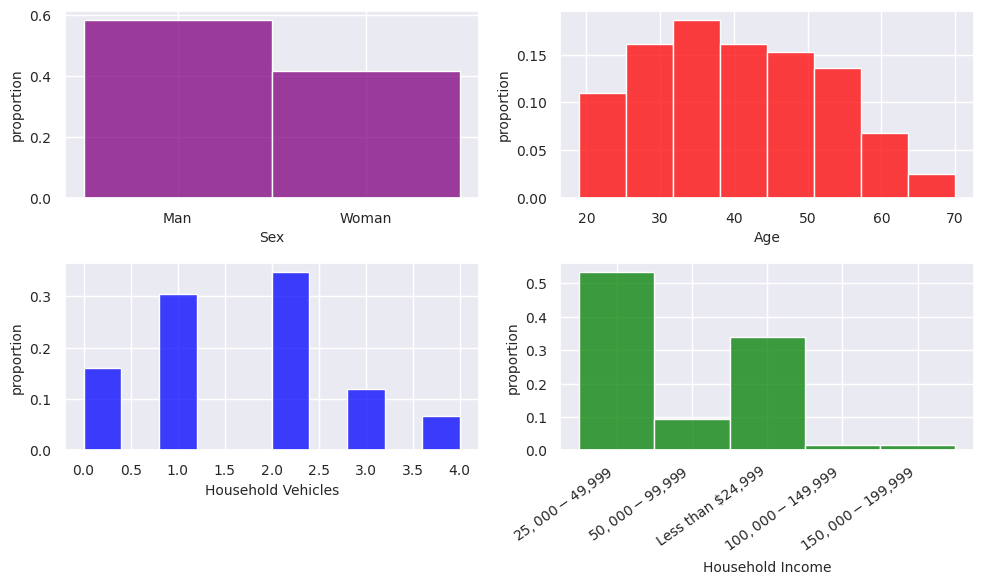

In [265]:
fig, axs = plt.subplots(2,2,figsize=(10,6))
sns.histplot(data=plot_data, x='GENDER', ax=axs[0,0], color='purple', stat='probability').set(xlabel='Sex',ylabel='proportion')
sns.histplot(data=plot_data, x='AGE', ax=axs[0,1], color='red', stat='probability').set(xlabel='Age',ylabel='proportion')
sns.histplot(data=plot_data, x='VEH_num', ax=axs[1,0], color='blue', stat='probability').set(xlabel='Household Vehicles',ylabel='proportion')
sns.histplot(data=pd.DataFrame(plot_data['HHINC'].dropna()), x='HHINC', ax=axs[1,1], color='green', stat='probability').set(xlabel='Household Income',ylabel='proportion')
plt.xticks(rotation=35, ha='right')
plt.tight_layout()

fig.savefig(file_name+".png", bbox_inches='tight')

## Modes in Mini vs Full Pilot

Figure 6 in the paper

In [266]:
# processing mini data
mini_data = pd.read_csv("../Data/trip_program.csv")
mini_data = mini_data[mini_data.program == 'prepilot']
print(len(mini_data))
MINI_DATA = mini_data.copy() #saving a copy for later

# Combine variable categories
mini_data = mini_data.replace('Gas Car, drove alone', 'Car')
mini_data = mini_data.replace('Gas Car, with others', 'Shared Car')
mini_data = mini_data.replace('Bikeshare', 'Shared Micromobility')
mini_data = mini_data.replace('Scooter share', 'Shared Micromobility')
mini_data = mini_data.replace('Regular Bike', 'Personal Micromobility')
mini_data = mini_data.replace('Skate board', 'Personal Micromobility')
mini_data = mini_data.replace('Train', 'Transit')
mini_data = mini_data.replace('Free Shuttle', 'Transit')
mini_data = mini_data.replace('Bus', 'Transit')
mini_data = mini_data.replace('Walk', 'Walk')
mini_data = mini_data.replace('Taxi/Uber/Lyft', 'Ridehail')
mini_data = mini_data.replace('Pilot ebike', 'E-Bike')

#filter out 'not a trip' trips
mini_data = mini_data[~mini_data['Mode_confirm'].isin(['Not a Trip'])]
mini_data = mini_data[~mini_data['Replaced_mode'].isin(['Not a Trip'])]
mini_data = mini_data[~mini_data['Trip_purpose'].isin(['not_a_trip'])]

print(len(mini_data))

2374
2323


In [267]:
mini_data.loc[mini_data['Mode_confirm']=='Personal Micromobility', 'Mode_confirm'] = 'Other'
mini_data.loc[mini_data['Mode_confirm']=='Shared Micromobility', 'Mode_confirm'] = 'Other'

t1 = mini_data.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','distance_miles']]
t1['proportion'] = t1['distance_miles'] / np.sum(t1.distance_miles)
t1['trip_type'] = 'All Trips'

t2 = mini_data[mini_data['Trip_purpose']=='Work'].copy()
t2 = t2.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','distance_miles']]
t2['proportion'] = t2['distance_miles'] / np.sum(t2.distance_miles)
t2['trip_type'] = 'Work Trips'
t2.loc[1.5] = 'Other', 0, 0, 'Work Trips'
t2 = t2.sort_index().reset_index(drop=True)

mini_data = pd.concat([t1,t2])
mini_data['Dataset'] = 'Minipilot'
mini_data.columns = ['Mode','Count','Proportion','Trip Type', "Dataset"]

# processing long data
plot_data = data.copy()
plot_data.loc[plot_data['Mode_confirm']=='Personal Micromobility', 'Mode_confirm'] = 'Other'
plot_data.loc[plot_data['Mode_confirm']=='Shared Micromobility', 'Mode_confirm'] = 'Other'

t1 = plot_data.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','distance_miles']]
t1['proportion'] = t1['distance_miles'] / np.sum(t1.distance_miles)
t1['trip_type'] = 'All Trips'

t2 = plot_data[plot_data['Trip_purpose']=='Work'].copy()
t2 = t2.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','distance_miles']]
t2['proportion'] = t2['distance_miles'] / np.sum(t2.distance_miles)
t2['trip_type'] = 'Work Trips'

plot_data = pd.concat([t1,t2])
plot_data['Dataset'] = 'Long Term'
plot_data.columns = ['Mode','Count','Proportion','Trip Type', "Dataset"]

plot_data = pd.concat([plot_data, mini_data])
plot_data

Mode  Count  Proportion   Trip Type    Dataset
0         Car  15763    0.256313   All Trips  Long Term
1      E-bike  17350    0.282118   All Trips  Long Term
2       Other   2127    0.034586   All Trips  Long Term
3    Ridehail    324    0.005268   All Trips  Long Term
4  Shared Car  14681    0.238719   All Trips  Long Term
5     Transit   1395    0.022683   All Trips  Long Term
6        Walk   9859    0.160312   All Trips  Long Term
0         Car   3758    0.282939  Work Trips  Long Term
1      E-bike   5959    0.448652  Work Trips  Long Term
2       Other    339    0.025523  Work Trips  Long Term
3    Ridehail     80    0.006023  Work Trips  Long Term
4  Shared Car   1167    0.087863  Work Trips  Long Term
5     Transit    296    0.022286  Work Trips  Long Term
6        Walk   1683    0.126713  Work Trips  Long Term
0         Car    487    0.209643   All Trips  Minipilot
1      E-bike    733    0.315540   All Trips  Minipilot
2       Other     28    0.012053   All Trips  Minipilot
3    Ridehail     65    0.027981   All Trips  Minipilot
4  Shared Car    687    0.295738   All Trips  Minipilot
5     Transit    155    0.066724   All Trips  Minipilot
6        Walk    168    0.072320   All Trips  Minipilot
0         Car    110    0.305556  Work Trips  Minipilot
1      E-bike    122    0.338889  Work Trips  Minipilot
2       Other      0    0.000000  Work Trips  Minipilot
3    Ridehail      1    0.002778  Work Trips  Minipilot
4  Shared Car    101    0.280556  Work Trips  Minipilot
5     Transit      3    0.008333  Work Trips  Minipilot
6        Walk     23    0.063889  Work Trips  Minipilot

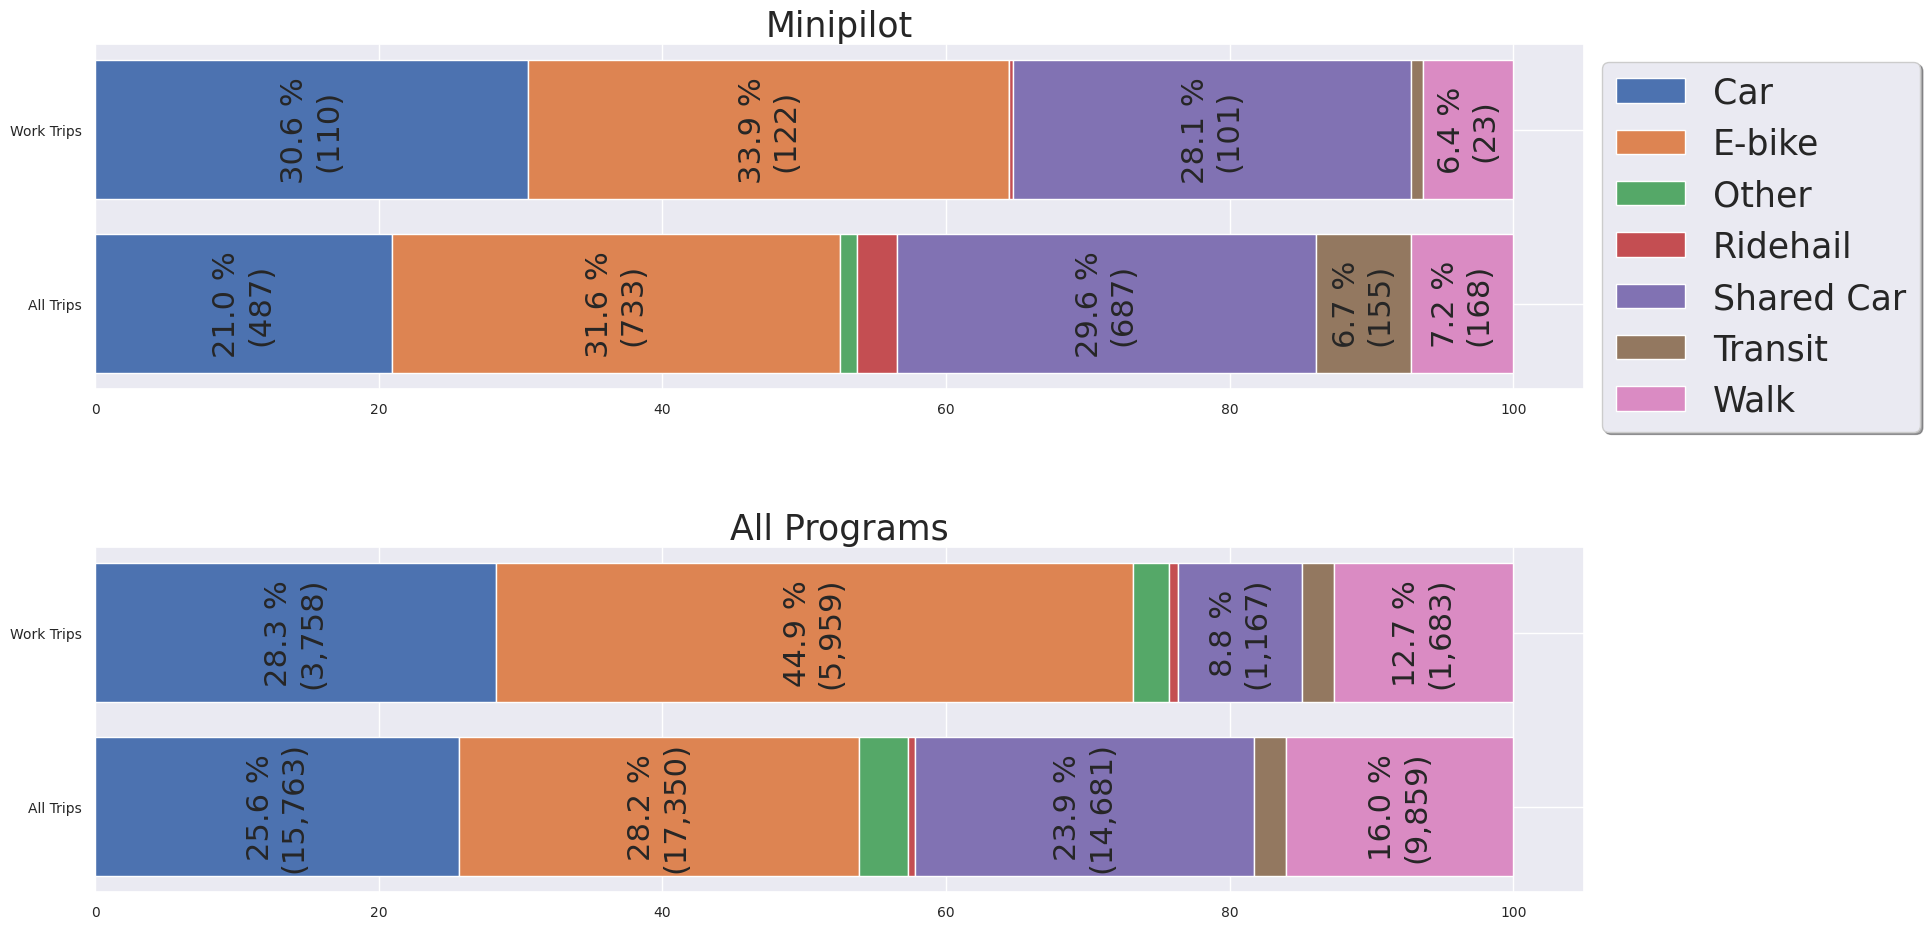

In [268]:
# make and save the chart

width = 0.8
fig, ax = plt.subplots(2,1, figsize=(20,10))
plt.rcParams.update({'font.size': 30}) 
running_total_mini = [0,0]
running_total_long = [0,0]
fig_data_mini = plot_data[plot_data['Dataset']=='Minipilot']
fig_data_long = plot_data[plot_data['Dataset']=='Long Term']

for mode in pd.unique(fig_data_mini.Mode):
    mini = fig_data_mini[fig_data_mini['Mode']==mode]
    long = fig_data_long[fig_data_long['Mode']==mode]
    
    labels = mini['Trip Type']
    vals = mini['Proportion']*100
    bar_labels = mini['Count']
    vals_str = [f'{y:.1f} %\n({x:,})' if y>5 else '' for x, y in zip(bar_labels, vals)]
    bar = ax[0].barh(labels, vals, width, left=running_total_mini, label=mode)
    ax[0].bar_label(bar, label_type='center', labels=vals_str, rotation=90, fontsize=22)
    running_total_mini[0] = running_total_mini[0]+vals.iloc[0]
    running_total_mini[1] = running_total_mini[1]+vals.iloc[1]

    labels = long['Trip Type']
    vals = long['Proportion']*100
    bar_labels = long['Count']
    vals_str = [f'{y:.1f} %\n({x:,})' if y>5 else '' for x, y in zip(bar_labels, vals)]
    bar = ax[1].barh(labels, vals, width, left=running_total_long, label=mode)
    ax[1].bar_label(bar, label_type='center', labels=vals_str, rotation=90, fontsize=22)
    running_total_long[0] = running_total_long[0]+vals.iloc[0]
    running_total_long[1] = running_total_long[1]+vals.iloc[1]

ax[0].set_title('Minipilot', fontsize=25)
ax[1].set_title('All Programs', fontsize=25)
ax[0].legend(bbox_to_anchor=(1,1), fancybox=True, shadow=True, fontsize=25)
plt.subplots_adjust(bottom=0.20)
fig.tight_layout()
plt.show()

## Mode Share by Program

figure 7 in the paper

In [269]:
# process the data for the clustered chart
data.program.unique()

array(['4c', 'cc', 'fc', 'pc', 'sc', 'vail'], dtype=object)

In [270]:
mode_data = data.copy()

#clean up the modes
mode_data.loc[mode_data['Mode_confirm']=='Personal Micromobility', 'Mode_confirm'] = 'Other'
mode_data.loc[mode_data['Mode_confirm']=='Shared Micromobility', 'Mode_confirm'] = 'Other'

program_list = ['4c', 'cc', 'fc', 'pc', 'sc', 'vail']
work_plot_data = []
all_plot_data = []
for program in program_list:
    program_data = mode_data[mode_data.program == program]

    t1 = program_data.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','distance_miles']]
    t1[program] = (t1['distance_miles'] / np.sum(t1.distance_miles)) * 100
    t1 = t1.set_index('Mode_confirm')
    t1 = t1.drop(columns = ['distance_miles'])
    all_plot_data.append(t1)

    t2 = program_data[program_data['Trip_purpose']=='Work'].copy()
    t2 = t2.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','distance_miles']]
    t2[program] = (t2['distance_miles'] / np.sum(t2.distance_miles)) * 100
    t2 = t2.set_index('Mode_confirm')
    t2 = t2.drop(columns = ['distance_miles'])
    work_plot_data.append(t2)
    
work_trips = pd.concat(work_plot_data, axis = 1)
all_trips = pd.concat(all_plot_data, axis = 1)

all_trips = all_trips.transpose()
work_trips = work_trips.transpose()

all_trips['program'] = all_trips.index
all_trips = all_trips.replace({'4c': 'Four Corners\n(Durango)', 
                               'cc': 'Comunity Cycles\n(Boulder)',
                               'sc': 'Smart Commute\n(Denver North)',
                               'pc':'Pueblo',
                               'vail':'Vail',
                               'fc':'Fort Collins'})
all_trips = all_trips.set_index('program')

work_trips['program'] = work_trips.index
work_trips = work_trips.replace({'4c': 'Four Corners\n(Durango)', 
                               'cc': 'Comunity Cycles\n(Boulder)',
                               'sc': 'Smart Commute\n(Denver North)',
                               'pc':'Pueblo',
                               'vail':'Vail',
                               'fc':'Fort Collins'})
work_trips = work_trips.set_index('program')

In [271]:
##COLUMN ORDERS MUST MATCH OR CHART MISREPRESENTS DATA

all_trips

Mode_confirm                         Car     E-bike     Other  Ridehail  \
program                                                                   
Four Corners\n(Durango)         9.678858  54.772525  4.727921  0.089206   
Comunity Cycles\n(Boulder)     18.233142  31.512405  4.600032  0.433365   
Fort Collins                   27.674550  31.015390  2.374249  0.056306   
Pueblo                         35.525794  26.539345  1.283778  0.103019   
Smart Commute\n(Denver North)  26.933702  11.801719  3.069368  2.931246   
Vail                           41.098748  17.918405  5.771905  0.069541   

Mode_confirm                   Shared Car   Transit       Walk  
program                                                         
Four Corners\n(Durango)         24.174844  0.579839   5.976806  
Comunity Cycles\n(Boulder)      21.262723  4.226304  19.732029  
Fort Collins                    22.738363  0.394144  15.746997  
Pueblo                          28.710674  0.245661   7.591727  
Smart Commute\n(Denver North)   30.095150  0.567833  24.600982  
Vail                            18.173389  4.844692  12.123319

In [272]:
work_trips['Ridehail'] = work_trips['Ridehail'].fillna(0)
work_trips['Transit'] = work_trips['Transit'].fillna(0)
work_trips = work_trips[['Car', 'E-bike', 'Other', 'Ridehail', 'Shared Car', 'Transit', 'Walk']]

work_trips

Mode_confirm                         Car     E-bike     Other  Ridehail  \
program                                                                   
Four Corners\n(Durango)         6.226415  78.867925  1.509434  0.000000   
Comunity Cycles\n(Boulder)     22.059954  54.938509  3.497310  0.403536   
Fort Collins                   32.752263  42.507543  3.151190  0.000000   
Pueblo                         51.745898  33.824148  0.420698  0.084140   
Smart Commute\n(Denver North)  13.959234  21.680049  2.532427  3.520692   
Vail                           25.307557  45.518453  0.702988  0.000000   

Mode_confirm                   Shared Car    Transit       Walk  
program                                                          
Four Corners\n(Durango)         12.264151   0.000000   1.132075  
Comunity Cycles\n(Boulder)       5.591852   4.016141   9.492698  
Fort Collins                     9.654710   0.335233  11.599061  
Pueblo                           7.909129   0.042070   5.973917  
Smart Commute\n(Denver North)   16.924027   0.432366  40.951204  
Vail                            10.720562  12.126538   5.623902

### make and save the clustered chart

In [273]:
#from https://stackoverflow.com/questions/22787209/how-to-have-clusters-of-stacked-bars
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title, fontsize = 22)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe

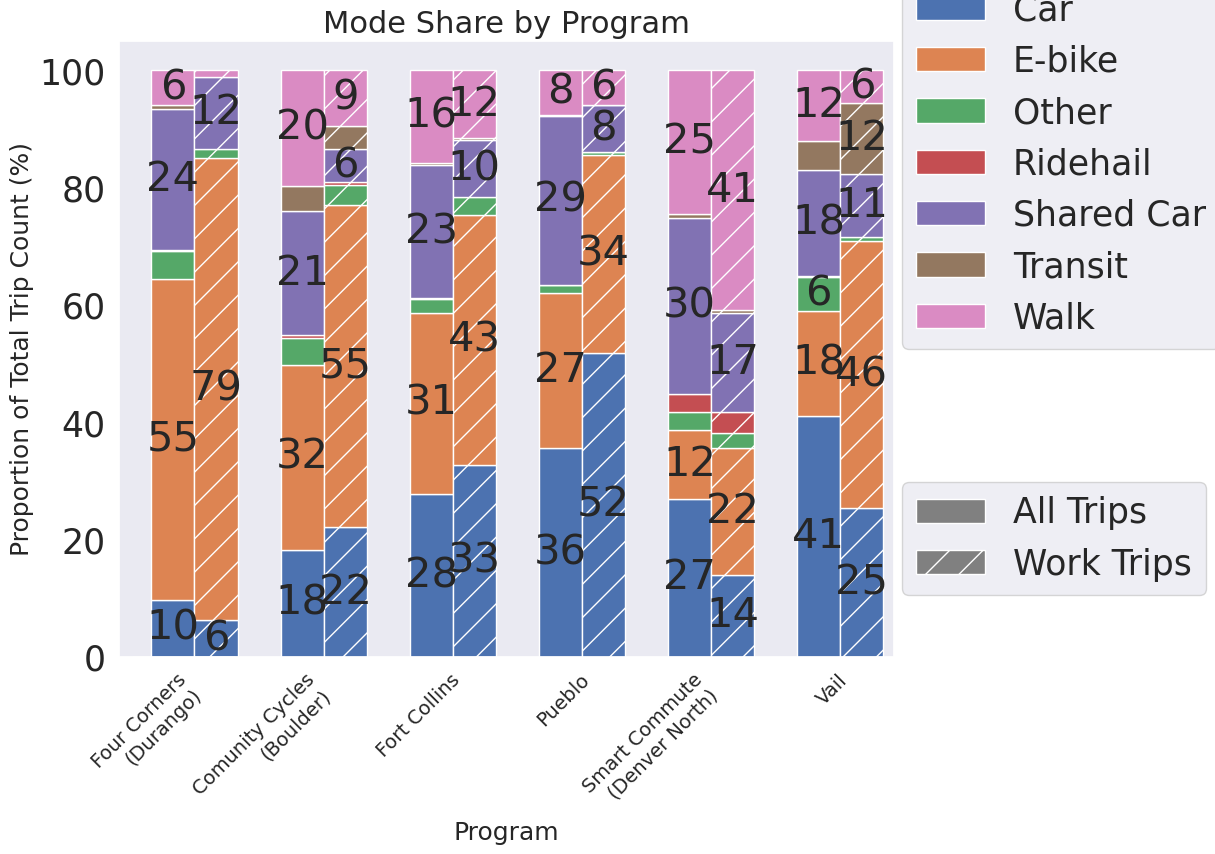

In [274]:
# Then, just call :
ax = plot_clustered_stacked([all_trips, work_trips],["All Trips", "Work Trips"], title = "Mode Share by Program")

for c in ax.containers:
    labels = [f'{round(v.get_height())}' if v.get_height() > 5 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
    
ax.set_xticklabels(all_trips.index, rotation=45, ha='right', fontsize=14)

ax.set_xlabel('Program', fontsize = 18)
ax.set_ylabel('Proportion of Total Trip Count (%)', fontsize = 18)

plt.savefig("CanBikeCO_report_mode_share_overview.jpeg", bbox_inches='tight')

## Trip Purpose Mini vs Full

figure 8 in the paper

In [275]:
#arrange the data
full_purpose_data = data.copy()
mini_purpose_data = MINI_DATA.copy()

#MINI DATA
mini_data = mini_purpose_data.copy()
mini_data = mini_data[~mini_data['Trip_purpose'].isin(['No travel'])]
mini_data.loc[mini_data['Trip_purpose']=='Religious', 'Trip_purpose'] = 'Other'
mini_data.loc[mini_data['Trip_purpose']=='School', 'Trip_purpose'] = 'Other'

t1 = mini_data.groupby(['Trip_purpose'], as_index=False).count()[['Trip_purpose','distance_miles']]
t1['proportion'] = t1['distance_miles'] / np.sum(t1.distance_miles)
t1['trip type'] = 'All Trips'

t2 = mini_data[mini_data['Mode_confirm']=='E-bike'].copy()
t2 = t2.groupby(['Trip_purpose'], as_index=False).count()[['Trip_purpose','distance_miles']]
t2['proportion'] = t2['distance_miles'] / np.sum(t2.distance_miles)
t2['trip type'] = 'E-Bike Trips'

mini_data = pd.concat([t1,t2])
mini_data['Dataset'] = 'Minipilot'
mini_data.columns = ['Purpose','Count','Proportion','Trip Type', "Dataset"]

#FULL DATA
plot_data = full_purpose_data.copy()
plot_data.loc[plot_data['Trip_purpose']=='Religious', 'Trip_purpose'] = 'Other'
plot_data.loc[plot_data['Trip_purpose']=='School', 'Trip_purpose'] = 'Other'
t1 = plot_data.groupby(['Trip_purpose'], as_index=False).count()[['Trip_purpose','distance_miles']]
t1['proportion'] = t1['distance_miles'] / np.sum(t1.distance_miles)
t1['trip type'] = 'All Trips'
t1.loc[len(t1.index)] = ['Pick-up/Drop off', 0, 0, 'All Trips']

t2 = plot_data[plot_data['Mode_confirm']=='E-bike'].copy()
t2 = t2.groupby(['Trip_purpose'], as_index=False).count()[['Trip_purpose','distance_miles']]
t2['proportion'] = t2['distance_miles'] / np.sum(t2.distance_miles)
t2['trip type'] = 'E-Bike Trips'
t2.loc[len(t2.index)] = ['Pick-up/Drop off', 0, 0, 'E-Bike Trips']

plot_data = pd.concat([t1,t2])
plot_data['Dataset'] = 'Long Term'
plot_data.columns = ['Purpose','Count','Proportion','Trip Type', "Dataset"]

plot_data = pd.concat([plot_data, mini_data])
# plot_data

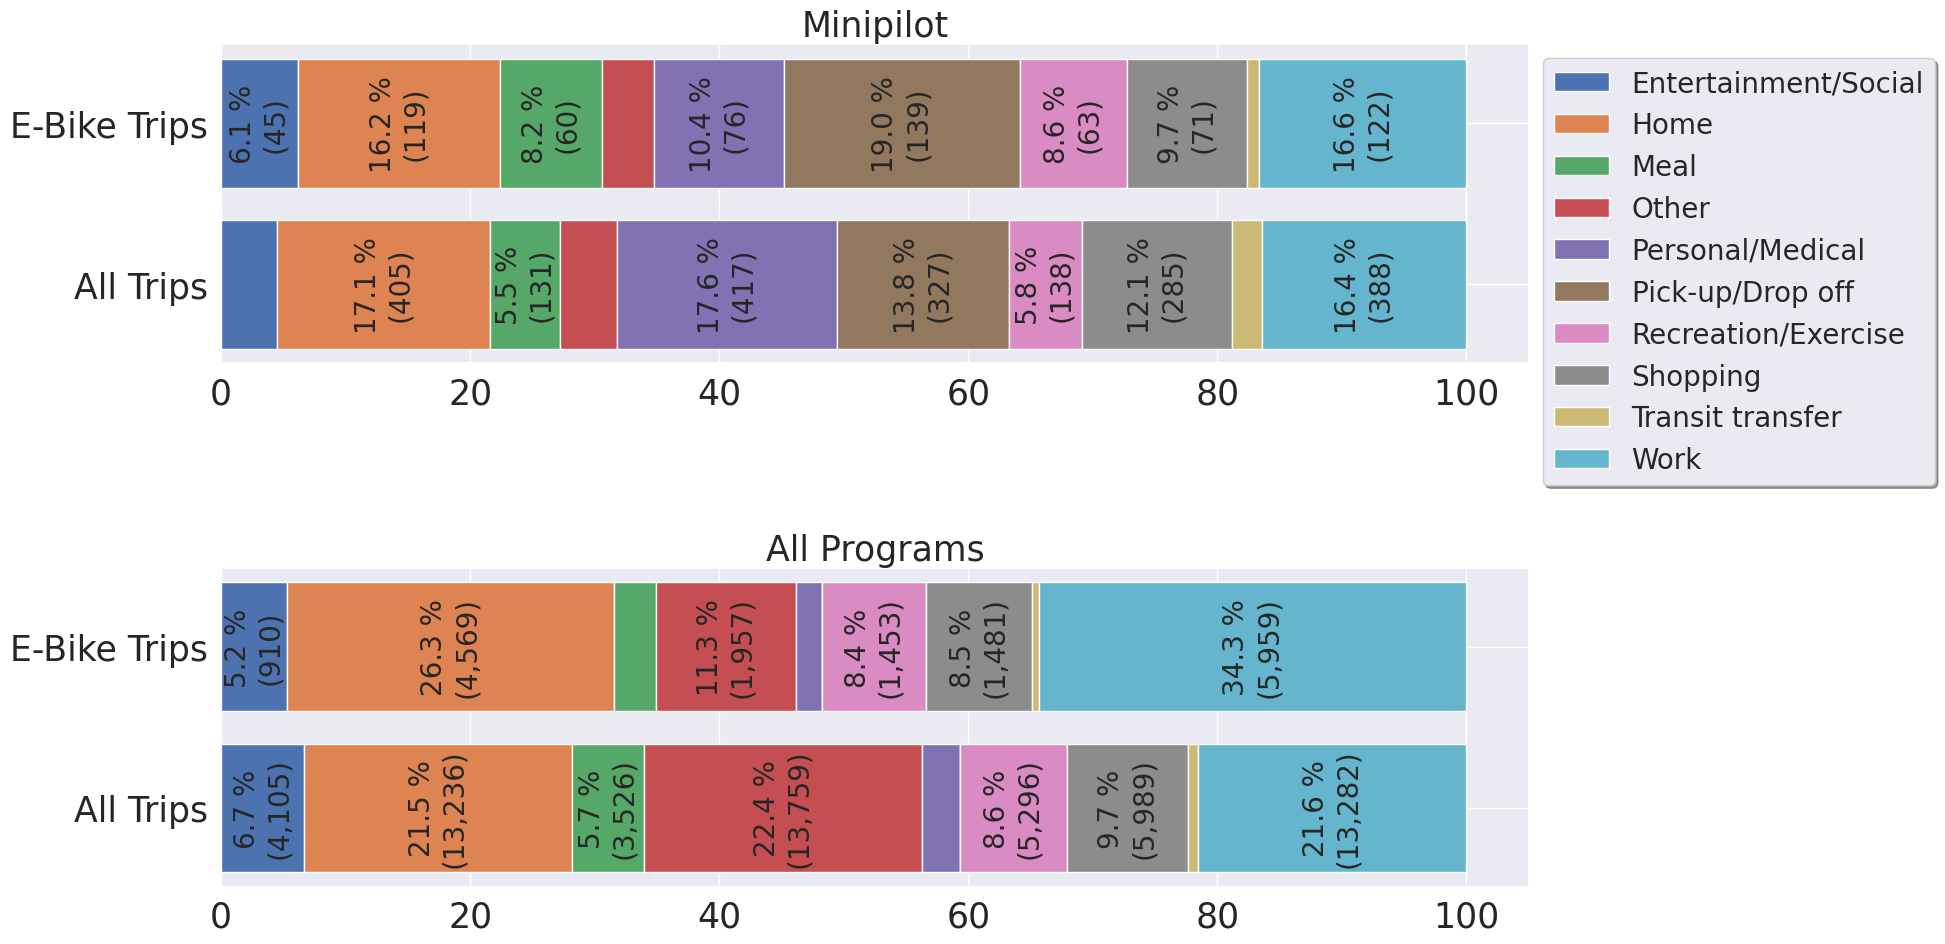

In [276]:
# create the chart

width = 0.8
fig, ax = plt.subplots(2,1, figsize=(20,10))
plt.rcParams.update({'font.size': 25}) 
running_total_mini = [0,0]
running_total_long = [0,0]
fig_data_mini = plot_data[plot_data['Dataset']=='Minipilot']
fig_data_long = plot_data[plot_data['Dataset']=='Long Term']

for purp in pd.unique(fig_data_mini.Purpose):
    mini = fig_data_mini[fig_data_mini['Purpose']==purp]
    long = fig_data_long[fig_data_long['Purpose']==purp]
    
    labels = mini['Trip Type']
    vals = mini['Proportion']*100
    bar_labels = mini['Count']
    vals_str = [f'{y:.1f} %\n({x:,})' if y>5 else '' for x, y in zip(bar_labels, vals)]
    bar = ax[0].barh(labels, vals, width, left=running_total_mini, label=purp)
    ax[0].bar_label(bar, label_type='center', labels=vals_str, rotation=90, fontsize=20)
    running_total_mini[0] = running_total_mini[0]+vals.iloc[0]
    running_total_mini[1] = running_total_mini[1]+vals.iloc[1]

    labels = long['Trip Type']
    vals = long['Proportion']*100
    bar_labels = long['Count']
    vals_str = [f'{y:.1f} %\n({x:,})' if y>5 else '' for x, y in zip(bar_labels, vals)]
    bar = ax[1].barh(labels, vals, width, left=running_total_long, label=purp)
    ax[1].bar_label(bar, label_type='center', labels=vals_str, rotation=90, fontsize=20)
    running_total_long[0] = running_total_long[0]+vals.iloc[0]
    running_total_long[1] = running_total_long[1]+vals.iloc[1]

ax[0].set_title('Minipilot', fontsize=25)
ax[1].set_title('All Programs', fontsize=25)
ax[0].legend(bbox_to_anchor=(1,1), fancybox=True, shadow=True, fontsize=20)
plt.subplots_adjust(bottom=0.20)
fig.tight_layout()
plt.savefig("CanBikeCO_report_purp_share.jpeg")
plt.show()

## Show what purposes diffrent programs used the e-bikes for

figure 9 in the paper

In [277]:
full_purpose_data = data.copy()
e_purpose = full_purpose_data[full_purpose_data.Mode_confirm == 'E-bike']

e_purpose.loc[e_purpose['Trip_purpose']=='Religious', 'Trip_purpose'] = 'Other'
e_purpose.loc[e_purpose['Trip_purpose']=='School', 'Trip_purpose'] = 'Other'

program_list = ['4c', 'cc', 'fc', 'pc', 'sc', 'vail']
all_plot_data = []
for program in program_list:
    program_data = e_purpose[mode_data.program == program]

    t1 = program_data.groupby(['Trip_purpose'], as_index=False).sum()[['Trip_purpose','distance_miles']]
    t1['distance_miles'].fillna(0, inplace=True)
    t1[program] = (t1['distance_miles'] / np.sum(t1.distance_miles)) * 100
    t1 = t1.set_index('Trip_purpose')
    t1 = t1.drop(columns = ['distance_miles'])
    all_plot_data.append(t1)
    
all_trips = pd.concat(all_plot_data, axis = 1)

all_trips = all_trips.transpose()

all_trips['program'] = all_trips.index
all_trips = all_trips.replace({'4c': 'Four Corners\n(Durango)', 
                               'cc': 'Comunity Cycles\n(Boulder)',
                               'sc': 'Smart Commute\n(Denver North)',
                               'pc':'Pueblo',
                               'vail':'Vail',
                               'fc':'Fort Collins'})
all_trips = all_trips.set_index('program')
# all_trips = all_trips.drop(columns=['Trip_purpose'])

all_trips

/tmp/ipykernel_20/3120951855.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  program_data = e_purpose[mode_data.program == program]
/tmp/ipykernel_20/3120951855.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t1 = program_data.groupby(['Trip_purpose'], as_index=False).sum()[['Trip_purpose','distance_miles']]
/tmp/ipykernel_20/3120951855.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  program_data = e_purpose[mode_data.program == program]
/tmp/ipykernel_20/3120951855.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t1 = program_

Trip_purpose                   Entertainment/Social       Home      Meal  \
program                                                                    
Four Corners\n(Durango)                    3.586900  33.540561  4.331342   
Comunity Cycles\n(Boulder)                 3.196050  31.032284  2.898926   
Fort Collins                               2.182344  27.295081  2.067012   
Pueblo                                    21.465674  12.907053  2.325854   
Smart Commute\n(Denver North)              2.324331  35.126383  1.852444   
Vail                                       3.251829  32.426163  5.338610   

Trip_purpose                       Other  Personal/Medical  \
program                                                      
Four Corners\n(Durango)         8.693450          0.236491   
Comunity Cycles\n(Boulder)      9.635477          1.789716   
Fort Collins                   11.727759          2.502932   
Pueblo                         15.152311          4.131477   
Smart Commute\n(Denver North)   2.791532          0.375686   
Vail                           13.396808          0.985428   

Trip_purpose                   Recreation/Exercise  Shopping  \
program                                                        
Four Corners\n(Durango)                   5.022724  9.145178   
Comunity Cycles\n(Boulder)               10.150997  5.976961   
Fort Collins                              7.898888  9.947937   
Pueblo                                   24.364485  5.881472   
Smart Commute\n(Denver North)             4.565950  2.674597   
Vail                                      5.274282  6.361933   

Trip_purpose                   Transit transfer       Work  
program                                                     
Four Corners\n(Durango)                0.170526  35.272829  
Comunity Cycles\n(Boulder)             0.523261  34.796328  
Fort Collins                           0.684368  35.693678  
Pueblo                                 0.408723  13.362951  
Smart Commute\n(Denver North)          0.135057  50.154019  
Vail                                   0.506718  32.458230

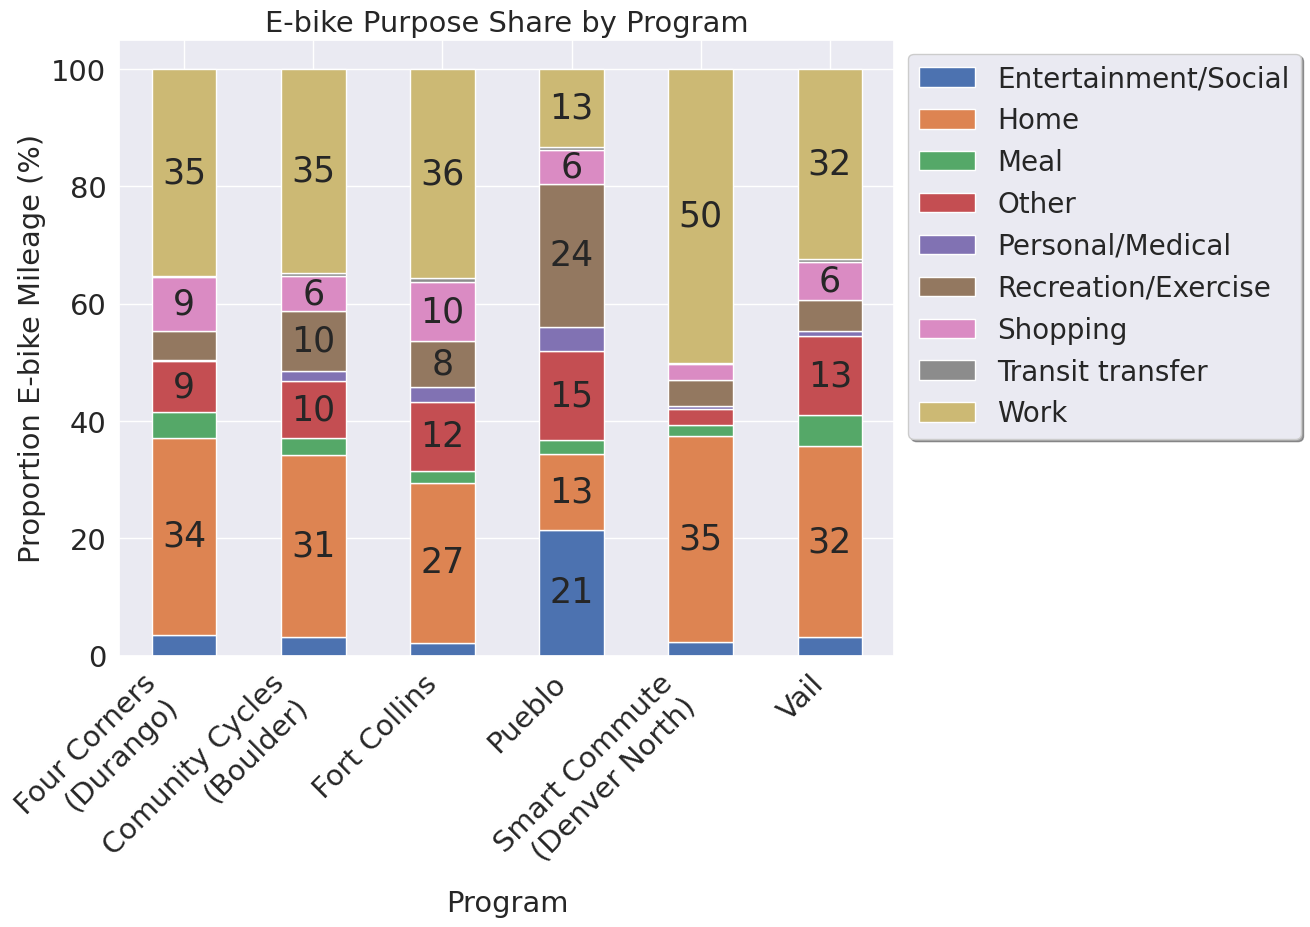

In [278]:
#https://stackoverflow.com/questions/41296313/stacked-bar-chart-with-centered-labels
ax = all_trips.plot.bar(stacked=True, 
                        title="E-bike Purpose Share by Program", 
                        ylabel="Proportion E-bike Mileage (%)",
                        xlabel = "Program",
                        rot = 45)

for c in ax.containers:
    labels = [f'{round(v.get_height())}' if v.get_height() > 5.5 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')

ax.set_xticklabels(all_trips.index, rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1,1), fancybox=True, shadow=True, fontsize=20)

plt.savefig("CanBikeCO_report_ebike_programs_purp_share.jpeg", bbox_inches='tight')


## Mode share by age

figure 11 in the paper

In [279]:
mode_data = data.copy() #complete set of cleaned data

age_counts = mode_data.groupby(['AGE'], as_index=False).count()[['AGE', 'user_id']]

In [280]:
bins = [18, 30, 42, 54, 66]
mode_data['age_bin'] = pd.cut(mode_data['AGE'], bins)


In [281]:
age_modes = mode_data.groupby(['age_bin', 'Mode_confirm'], as_index=False).count()[['age_bin', 'Mode_confirm','distance_miles']]
age_modes['proportion'] = age_modes['distance_miles'] / np.sum(age_modes.distance_miles)

list_age_modes = []
for age_bin in age_modes.age_bin.unique():
    age_data = mode_data[mode_data['age_bin'] == age_bin]

    t1 = age_data.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','distance_miles']]
    t1['distance_miles'].fillna(0, inplace=True)
    t1[age_bin] = (t1['distance_miles'] / np.sum(t1.distance_miles)) * 100
    t1 = t1.set_index('Mode_confirm')
    t1 = t1.drop(columns = ['distance_miles'])
    list_age_modes.append(t1)
        
age_modes = pd.concat(list_age_modes, axis = 1)

age_modes = age_modes.transpose()

age_modes = age_modes.fillna(0)

age_modes

Mode_confirm        Car     E-bike     Other  Personal Micromobility  \
(18, 30]      10.925905  33.245804  3.447882                2.705788   
(30, 42]      24.976826  25.351049  2.389535                1.441961   
(42, 54]      24.679417  32.959625  0.534916                1.179746   
(54, 66]      41.623117  26.109233  0.348396                0.655805   

Mode_confirm  Ridehail  Shared Car  Shared Micromobility   Transit       Walk  
(18, 30]      0.182669   26.372874              0.616509  3.596301  18.906268  
(30, 42]      0.878910   25.282384              0.233460  2.379236  17.066639  
(42, 54]      0.322415   26.679856              0.073276  2.601304  10.969444  
(54, 66]      0.051235   13.433753              0.051235  0.327902  17.399324

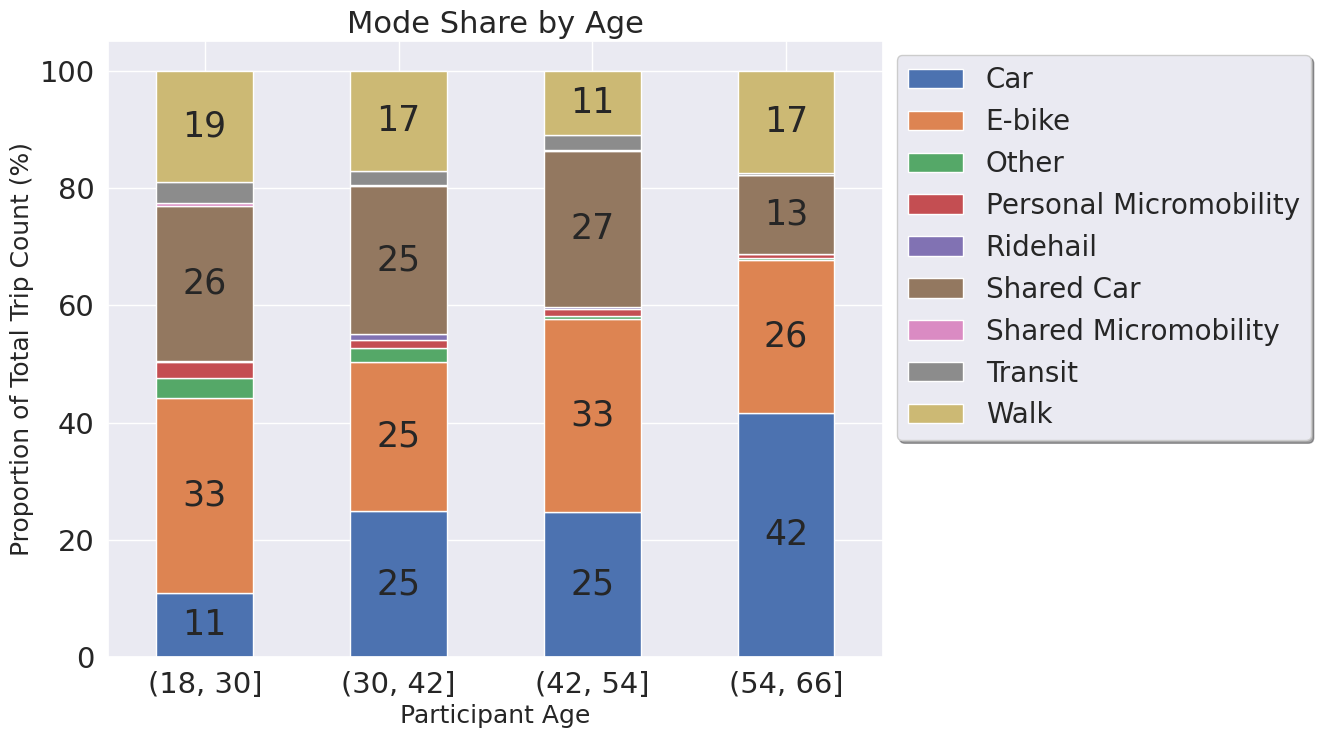

In [282]:
#https://stackoverflow.com/questions/41296313/stacked-bar-chart-with-centered-labels
ax = age_modes.plot.bar(stacked=True, 
                        title="Mode Share by Age", 
                        ylabel="Proportion of Total Trip Count (%)",
                        xlabel = "Participant Age",
                        rot = 0)

for c in ax.containers:
    labels = [f'{round(v.get_height())}' if v.get_height() > 5.5 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')

# ax.set_xticklabels(age_modes.index, rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1,1), fancybox=True, shadow=True, fontsize=20)

ax.set_xlabel("Participant Age", fontsize = 18)
ax.set_ylabel("Proportion of Total Trip Count (%)", fontsize = 18)
ax.set_title("Mode Share by Age", fontsize = 22)

plt.savefig("CanBikeCO_report_age_mode_share.jpeg", bbox_inches='tight')

## e-bike distances by program

figure 5 in the paper

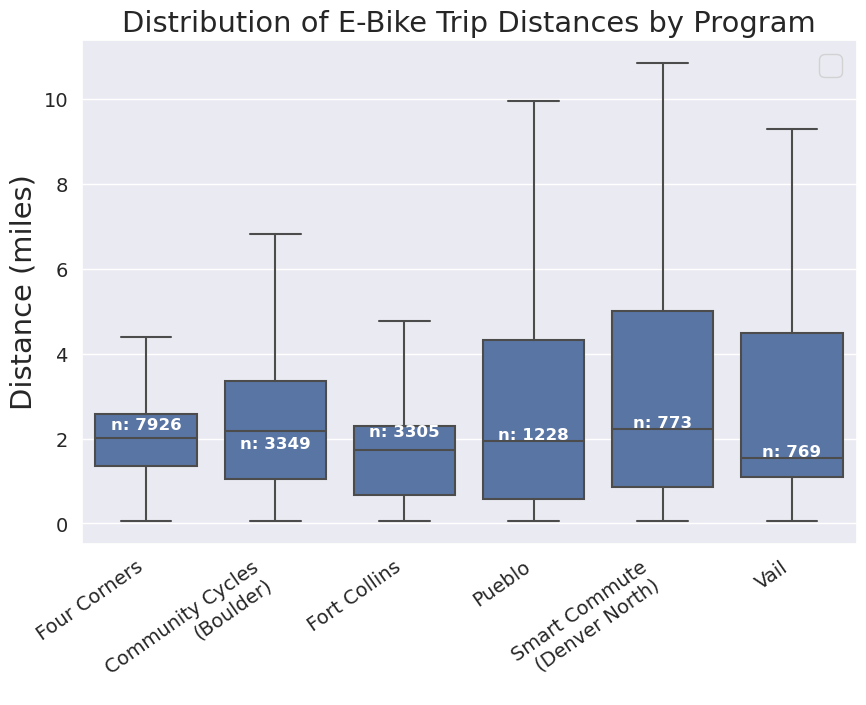

In [284]:
# Distribution of distances by program
plot_data = data.copy()
plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data['Program'] = plot_data['program'].replace(['4c','cc','fc','pc','sc','vail'],['Four Corners','Community Cycles\n(Boulder)','Fort Collins','Pueblo','Smart Commute\n(Denver North)','Vail'])

plot_title = 'Distribution of E-Bike Trip Distances by Program'
ylab = 'Distance (miles)'

fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(ax=ax, data=plot_data, x='Program', y='distance_miles', hue='Mode_confirm', showfliers=False).set(title=plot_title, xlabel='', ylabel=ylab)
plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=35, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.legend([])

# Calculate number of obs per group & median to position labels
medians = plot_data.groupby(['Program'])['distance_miles'].median().values
nobs = plot_data['Program'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            medians[tick] + 0.03,
            nobs[tick],
            horizontalalignment='center',
            size='12',
            color='w',
            weight='semibold')
 
plt.savefig("CanBikeCO_report_e-bike_miles_dist.jpeg", bbox_inches='tight')

## E-bike trips across occuptations

figures 13 and 25

In [285]:
data.columns

Index(['Unnamed: 0.1', '_id', 'perno', 'metadata_key', 'metadata_platform',
       'metadata_write_ts', 'metadata_time_zone',
       'metadata_write_local_dt_year', 'metadata_write_local_dt_month',
       'metadata_write_local_dt_day',
       ...
       'distance_miles', 'is_ebike', 'HHINC_NUM', 'PINC', 'Mode', 'PINC_NUM',
       'VEH_num', 'DRIVERS', 'DRIVERS_num', 'veh_per_driver'],
      dtype='object', length=106)

In [286]:
data = data.copy()
data['occupation_cat'] = data['which_best_describes_your_primary_job?'].replace(['Sales or service',
                                                                                 'Manufacturing, construction, maintenance, or farming',                                                                            
                                                                                 'Janitorial',
                                                                                 'Professional, managerial, or technical',
                                                                                 'Clerical or administrative support',
                                                                                 'Teacher',
                                                                                 'Medical',
                                                                                 'CNA',
                                                                                 'Restaurant manager',
                                                                                 'Co op laundry',
                                                                                 'Cook',
                                                                                 'Nurse',
                                                                                 'Dining Services',
                                                                                 'Security',
                                                                                 'Food service',
                                                                                 'Csu custodian',
                                                                                 'Residential Dining Services',
                                                                                 'education/early childhood',
                                                                                 'Inbound cs',
                                                                                 'Custodial Maintanace',
                                                                                 'Amazon',
                                                                                 'Custodian',
                                                                                 'Hockey rink',
                                                                                 'Pastry chef and line cook',                                                                                 
                                                                                 'Cooking',
                                                                                 'Education non-profit manager',
                                                                                 'Healthcare',
                                                                                 'Chef',
                                                                                 'Accounting Technician',
                                                                                 'Caregiver/ Qmap',
                                                                                 'Caregiver',
                                                                                 'Health care',
                                                                                 'Medical field'],
                                                                                ['Sales or Service',
                                                                                 'Manufacturing, Construction, Maintenance, or Farming',
                                                                                 'Custodial',
                                                                                 'Professional, Managerial, or Technical',
                                                                                 'Clerical or Administrative Support',
                                                                                 'Education',
                                                                                 'Medical/Healthcare',
                                                                                 'Medical/Healthcare',
                                                                                 'Professional, Managerial, or Technical',
                                                                                 'Sales or Service',
                                                                                 'Sales or Service',
                                                                                 'Medical/Healthcare',
                                                                                 'Sales or Service',
                                                                                 'Professional, Managerial, or Technical',
                                                                                 'Sales or Service',
                                                                                 'Custodial',
                                                                                 'Sales or Service',
                                                                                 'Education',
                                                                                 'Professional, Managerial, or Technical',
                                                                                 'Custodial',
                                                                                 'Sales or Service',
                                                                                 'Custodial',
                                                                                 'Sales or Service',
                                                                                 'Sales or Service',
                                                                                 'Sales or Service',
                                                                                 'Education',
                                                                                 'Medical/Healthcare',
                                                                                 'Sales or Service',
                                                                                 'Professional, Managerial, or Technical',
                                                                                 'Medical/Healthcare',
                                                                                 'Medical/Healthcare',
                                                                                 'Medical/Healthcare',
                                                                                 'Medical/Healthcare'])
data['occupation_cat'].unique()

array(['Sales or Service', 'Cooking ', 'Food Service',
       'Professional, Managerial, or Technical',
       'Manufacturing, Construction, Maintenance, or Farming',
       'Clerical or Administrative Support', 'Medical/Healthcare',
       'Accounting Technician ', 'Education ', 'Education', 'Custodial',
       nan, 'Csu custodian ', 'Custodial ', 'Maintenance ', 'Maintenance',
       'Janitorial ', 'Amazon ', 'Custodial Maintanace ', 'Hockey rink '],
      dtype=object)

In [287]:
data['occupation_cat']= data['occupation_cat'].replace(['Food Service', 'Cooking ', 'Accounting Technician ','Education ',
                                                       'Csu custodian ','Custodial ','Maintenance ','Maintenance','Janitorial ',
                                                       'Amazon ', 'Custodial Maintanace ', 'Hockey rink '],
                                                      ['Sales or Service' , 'Sales or Service', 'Professional, Managerial, or Technical',
                                                      'Education', 'Custodial', 'Custodial', 'Custodial', 'Custodial', 'Custodial',
                                                      'Sales or Service','Custodial' ,'Sales or Service'])

data['occupation_cat'] = data['occupation_cat'].replace(['Manufacturing, Construction, Maintenance, or Farming', 'Professional, Managerial, or Technical', 'Clerical or Administrative Support'],
                                                        ['Manufacturing, Construction,\nMaintenance, or Farming', 'Professional, Managerial,\nor Technical', 'Clerical or\nAdministrative Support'])
data['occupation_cat'].unique()

array(['Sales or Service', 'Professional, Managerial,\nor Technical',
       'Manufacturing, Construction,\nMaintenance, or Farming',
       'Clerical or\nAdministrative Support', 'Medical/Healthcare',
       'Education', 'Custodial', nan], dtype=object)

In [288]:
plot_data_1=data[data['occupation_cat'].notnull()]

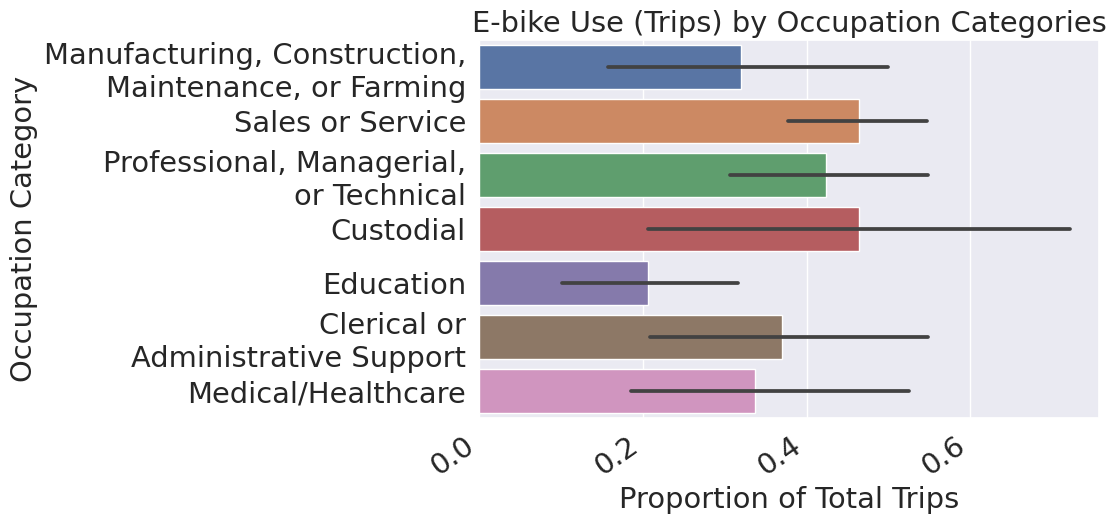

In [289]:
# proportion of trips by occupation
plot_data = plot_data_1.copy()

t1 = plot_data.groupby(['user_id','Mode_confirm'], as_index=False).count()[['user_id','Mode_confirm','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.groupby(['user_id'], as_index=False).count()[['user_id','distance_miles']]
plot_data = t1.merge(t2, on='user_id')
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)
t3 = data.copy().groupby(['occupation_cat','user_id'], as_index=False).nth(0)[['occupation_cat','user_id']]

plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data = plot_data.merge(t3, on='user_id')

plot_title = 'E-bike Use (Trips) by Occupation Categories'
ylab='Occupation Category'
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(data= plot_data, x='proportion' , y='occupation_cat', estimator=np.mean).set(title=plot_title,xlabel='Proportion of Total Trips',ylabel=ylab)
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)

plt.savefig("CanBikeCO_report_occ_ebike_trips.jpeg", bbox_inches='tight')

In [290]:
data['induced']=np.where(data['Replaced_mode']=='No Travel', 'Induced', 'Non-induced')

In [291]:
data['Program'] = data['program'].replace(['4c','cc','fc','pc','sc','vail'],['Four Corners (Durango)','Community Cycles (Boulder)','Fort Collins','Pueblo County','Smart Commute (Denver North)','Vail'])

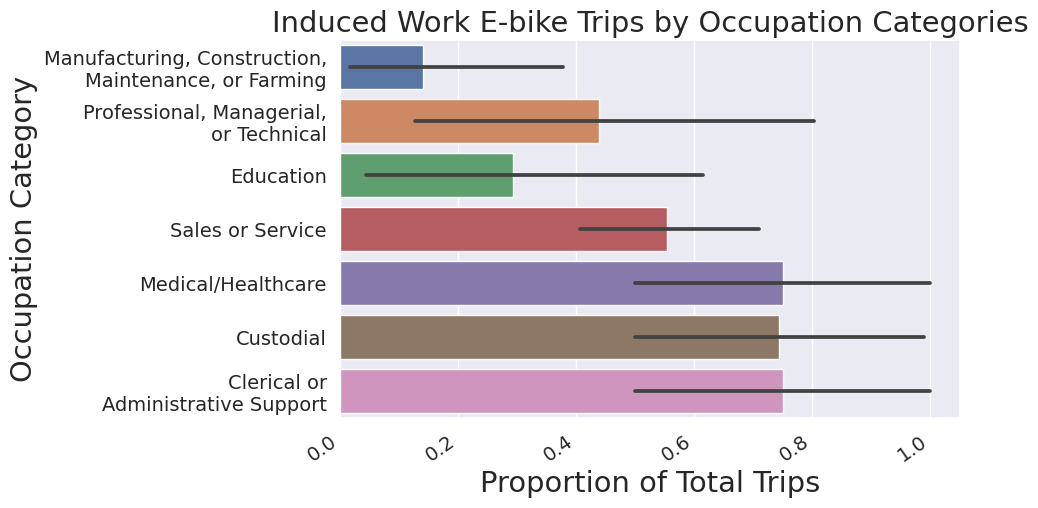

In [292]:
# proportion of induced trips by occupation
plot_data = data.copy()
plot_data = plot_data[(plot_data['induced']=='Induced') & (plot_data['Trip_purpose']=='Work')]

t1 = plot_data.groupby(['user_id','Mode_confirm'], as_index=False).count()[['user_id','Mode_confirm','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.groupby(['user_id'], as_index=False).count()[['user_id','distance_miles']]
plot_data = t1.merge(t2, on='user_id')
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)
t3 = data.copy().groupby(['occupation_cat','user_id'], as_index=False).nth(0)[['occupation_cat','user_id']]

plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data = plot_data.merge(t3, on='user_id')

plot_title = 'Induced Work E-bike Trips by Occupation Categories'
ylab='Proportion of Total Trips'
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(data= plot_data, x='proportion' , y='occupation_cat', estimator=np.mean).set(title=plot_title,xlabel=ylab,ylabel='Occupation Category')
plt.xticks(rotation=35, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.subplots_adjust(bottom=0.25)

plt.savefig("CanBikeCO_report_occ_induced_ebike_trips.jpeg", bbox_inches='tight')

## substitutions
Figure num 23

/tmp/ipykernel_20/3833549607.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_order = plot_data.groupby(['Replaced_mode'], as_index=False).mean().sort_values('proportion', ascending=False).Replaced_mode
/tmp/ipykernel_20/3833549607.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  labels = plot_data.groupby(['Replaced_mode'], as_index=False).mean().sort_values('proportion', ascending=False).Replaced_mode


[Text(0, 10, '0.34'),
 Text(0, 10, '0.22'),
 Text(0, 10, '0.11'),
 Text(0, 10, '0.10'),
 Text(0, 10, '0.09'),
 Text(0, 10, '0.08'),
 Text(0, 10, '0.03'),
 Text(0, 10, '0.02'),
 Text(0, 10, '0.00'),
 Text(0, 10, '0.00')]

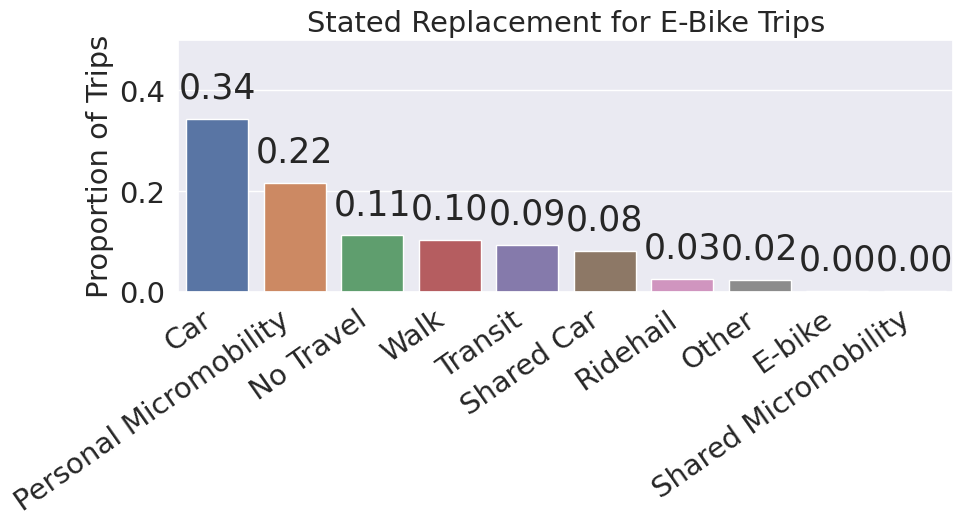

In [293]:
# Substitution rate of ebike trips
plot_data = data.copy()
plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
t1 = plot_data.groupby(['Mode_confirm','Replaced_mode'], as_index=False).count()[['Mode_confirm','Replaced_mode','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','distance_miles']]
plot_data = t1.merge(t2, on='Mode_confirm')
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)

data_order = plot_data.groupby(['Replaced_mode'], as_index=False).mean().sort_values('proportion', ascending=False).Replaced_mode
labels = plot_data.groupby(['Replaced_mode'], as_index=False).mean().sort_values('proportion', ascending=False).Replaced_mode

plot_title='Stated Replacement for E-Bike Trips'
ylab='Proportion of Trips'

fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(data=plot_data, x='Replaced_mode', y='proportion', estimator=np.mean, order=data_order).set(title=plot_title,xlabel='',ylabel=ylab,ylim=(0,.5))
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.bar_label(ax.containers[0], fmt='%.2f', padding=10)

## E-bike Mileage change over time
Figure #20

/tmp/ipykernel_20/2327594662.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t1 = plot_data.groupby(['user_id','date','Mode_confirm'], as_index=False).sum()[['user_id','date','Mode_confirm','distance_miles']]
/tmp/ipykernel_20/2327594662.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t2 = plot_data.groupby(['user_id','Program','date'], as_index=False).sum()[['user_id','Program','date','distance_miles']]


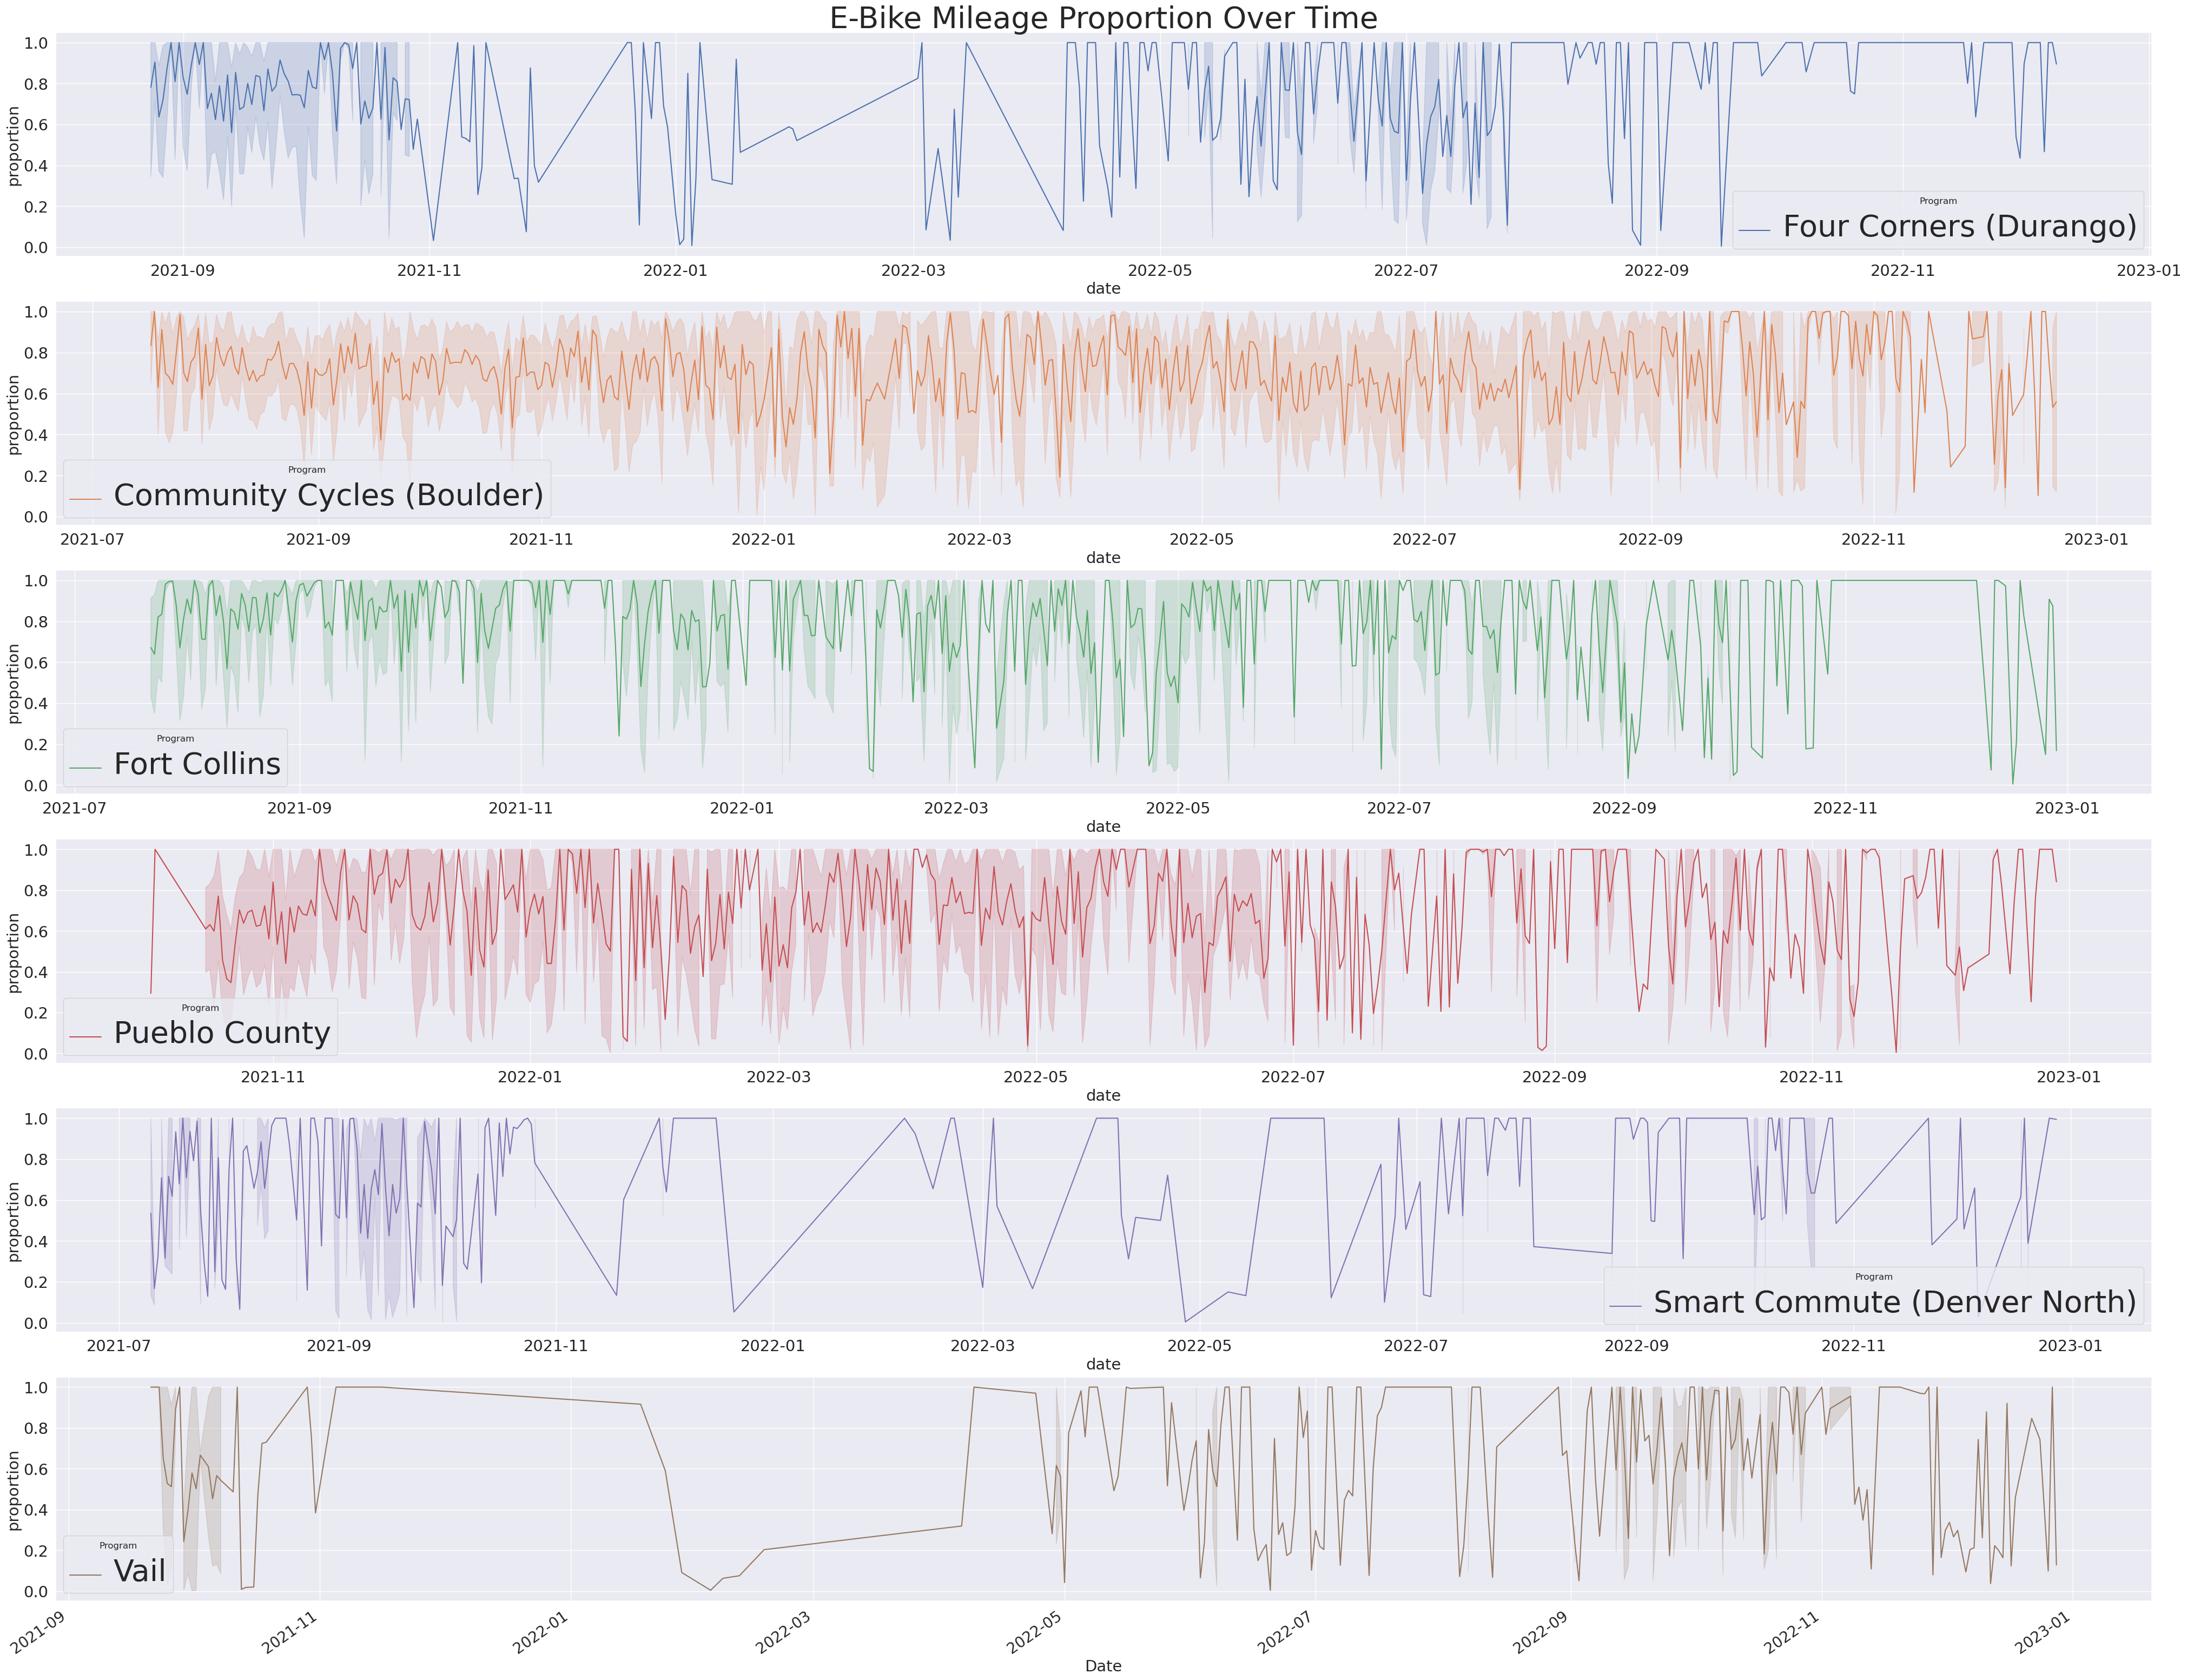

In [295]:
# How ebike mileage changes over time
from datetime import datetime
plot_data = data.copy()
plot_data ['date'] = pd.to_datetime(plot_data['date_time'])
plot_data['Program'] = plot_data['program'].replace(['4c','cc','fc','pc','sc','vail'],['Four Corners (Durango)','Community Cycles (Boulder)','Fort Collins','Pueblo County','Smart Commute (Denver North)','Vail'])
t1 = plot_data.groupby(['user_id','date','Mode_confirm'], as_index=False).sum()[['user_id','date','Mode_confirm','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.groupby(['user_id','Program','date'], as_index=False).sum()[['user_id','Program','date','distance_miles']]
plot_data = t1.merge(t2, on=['user_id','date'])
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)
plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data = plot_data[plot_data['distance_miles_y'].notnull()]

plot_title = 'E-Bike Mileage Proportion Over Time'
fig, ax = plt.subplots(6,1, figsize=(50,50))
sns.lineplot(data=plot_data[plot_data.Program == "Four Corners (Durango)"], x='date', y='proportion',color="red", hue='Program', estimator=np.mean, ax=ax[0])
ax[0].set_title(plot_title, fontsize=40)
sns.lineplot(data=plot_data[plot_data.Program == "Community Cycles (Boulder)"], x='date', y='proportion', color="blue",hue='Program',estimator=np.mean, ax=ax[1], palette=["C1"])
sns.lineplot(data=plot_data[plot_data.Program == "Fort Collins"], x='date', y='proportion', color="green",hue='Program',estimator=np.mean, ax=ax[2], palette=["C2"])
sns.lineplot(data=plot_data[plot_data.Program == "Pueblo County"], x='date', y='proportion',color="cyan",hue='Program', estimator=np.mean, ax=ax[3], palette=["C3"])
sns.lineplot(data=plot_data[plot_data.Program == "Smart Commute (Denver North)"], x='date', y='proportion',color="purple",hue='Program', estimator=np.mean, ax=ax[4], palette=["C4"])
sns.lineplot(data=plot_data[plot_data.Program == "Vail"], x='date', y='proportion', color="orange",hue='Program',estimator=np.mean, ax=ax[5], palette=["C5"])
ax[5].set(xlabel='Date')
plt.setp(ax[0].get_legend().get_texts(), fontsize='40')
plt.setp(ax[1].get_legend().get_texts(), fontsize='40')
plt.setp(ax[2].get_legend().get_texts(), fontsize='40')
plt.setp(ax[3].get_legend().get_texts(), fontsize='40')
plt.setp(ax[4].get_legend().get_texts(), fontsize='40')
plt.setp(ax[5].get_legend().get_texts(), fontsize='40')
plt.xticks(rotation=35, ha='right', fontsize=20)
plt.subplots_adjust(bottom=0.30)
fig.savefig(r'mileage_over_time', bbox_inches='tight')

## distributions of distances and durations by mode

Figures #4a and 4b

In [296]:
sns.set_palette('Set1', 9)

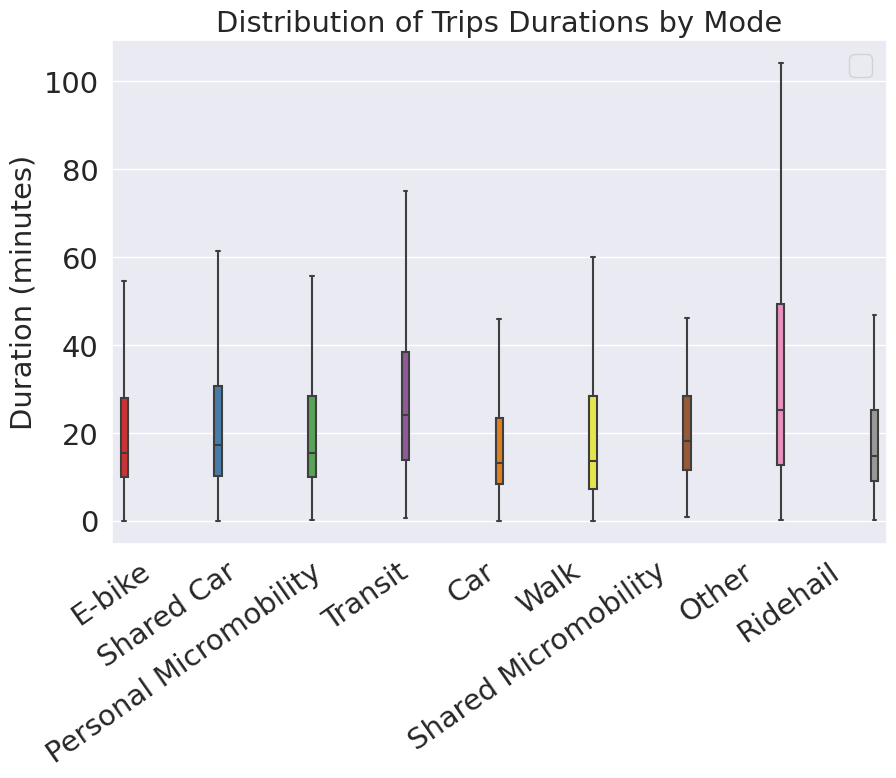

In [297]:
# Distribution of distances
plot_data = data.copy()
plot_title = 'Distribution of Trips Durations by Mode'
ylab = 'Duration (minutes)'

fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(ax=ax, data=plot_data, x='Mode_confirm', y='duration', hue='Mode_confirm', showfliers=False).set(title=plot_title, xlabel='', ylabel=ylab)
plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=35, ha='right')
plt.legend([])

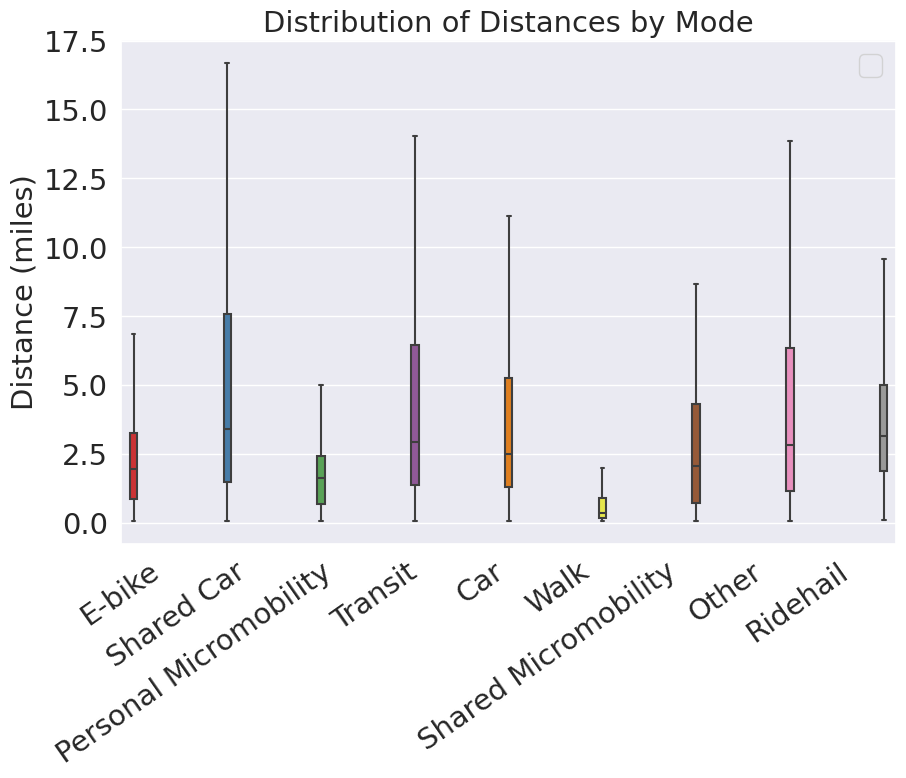

In [298]:
# Distribution of distances by program
plot_data = data.copy()

plot_title = 'Distribution of Distances by Mode'
ylab = 'Distance (miles)'

fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(ax=ax, data=plot_data, x='Mode_confirm', y='distance_miles', hue='Mode_confirm', showfliers=False).set(title=plot_title, xlabel='', ylabel=ylab)
plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=35, ha='right')
plt.legend([])

In [299]:
sns.set_palette('Set2', 6)

### Proportion of trips that are ebike by income group

Figure #12

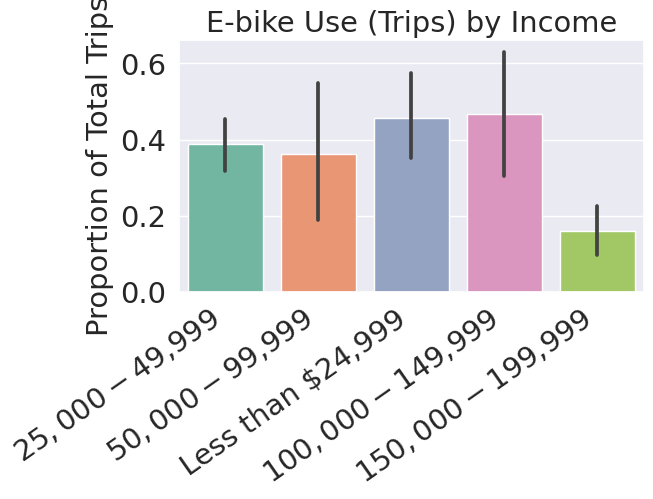

In [300]:
# Proportion of trips that are ebike by income group
plot_data = data.copy()

t1 = plot_data.groupby(['user_id','Mode_confirm'], as_index=False).count()[['user_id','Mode_confirm','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.groupby(['user_id'], as_index=False).count()[['user_id','distance_miles']]
plot_data = t1.merge(t2, on='user_id')
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)
t3 = data.copy().groupby(['HHINC','user_id'], as_index=False).nth(0)[['HHINC','user_id']]

plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data = plot_data.merge(t3, on='user_id')

file_name = 'CanBikeCO_report_income_trips'
ylab='Proportion of Total Trips'
plot_title = 'E-bike Use (Trips) by Income'
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=plot_data, x='HHINC', y='proportion', estimator=np.mean).set(title=plot_title,xlabel='',ylabel=ylab)
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(file_name+".png", bbox_inches='tight')

## Proportion of miles that are ebike by income group

figure #15

/tmp/ipykernel_20/4077712807.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t1 = plot_data.groupby(['user_id','Mode_confirm'], as_index=False).sum()[['user_id','Mode_confirm','distance_miles']]
/tmp/ipykernel_20/4077712807.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t2 = plot_data.groupby(['user_id'], as_index=False).sum()[['user_id','distance_miles']]


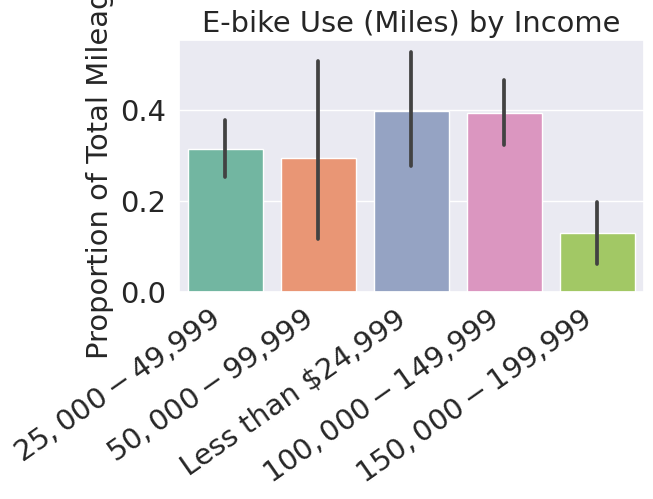

In [302]:
# Proportion of miles that are ebike by income group
plot_data = data.copy()

t1 = plot_data.groupby(['user_id','Mode_confirm'], as_index=False).sum()[['user_id','Mode_confirm','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.groupby(['user_id'], as_index=False).sum()[['user_id','distance_miles']]
plot_data = t1.merge(t2, on='user_id')
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)
t3 = data.copy().groupby(['HHINC','user_id'], as_index=False).nth(0)[['HHINC','user_id']]

plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data = plot_data.merge(t3, on='user_id')

file_name = 'CanBikeCO_report_income_mileages'
ylab='Proportion of Total Mileage'
plot_title = 'E-bike Use (Miles) by Income'
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=plot_data, x='HHINC', y='proportion', estimator=np.mean).set(title=plot_title,xlabel='',ylabel=ylab)
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(file_name+".png", bbox_inches='tight')

## Proportion of trips that are ebike by income group

figure #14

In [303]:
sns.set_palette('Paired', 5)

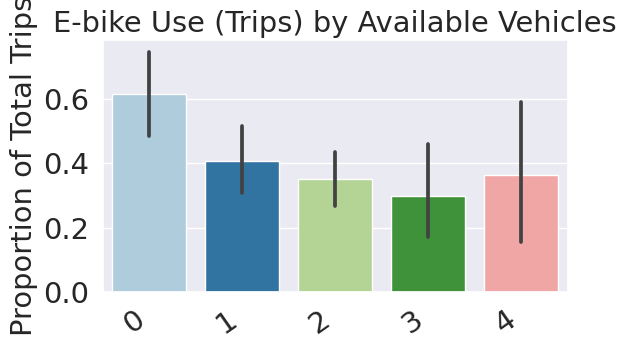

In [304]:
plot_data = data.copy()

t1 = plot_data.groupby(['user_id','Mode_confirm'], as_index=False).count()[['user_id','Mode_confirm','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.groupby(['user_id'], as_index=False).count()[['user_id','distance_miles']]
plot_data = t1.merge(t2, on='user_id')
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)
t3 = data.copy().groupby(['VEH_num','user_id'], as_index=False).nth(0)[['VEH_num','user_id']]

plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data = plot_data.merge(t3, on='user_id')

file_name = 'CanBikeCO_report_veh_trips'
plot_title = 'E-bike Use (Trips) by Available Vehicles'
ylab='Proportion of Total Trips'
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=plot_data, x='VEH_num', y='proportion', estimator=np.mean).set(title=plot_title,xlabel='',ylabel=ylab)
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(file_name+".png", bbox_inches='tight')

## mileage over time

figure #18 and #19

In [305]:
sns.set_palette('Set1', 3)

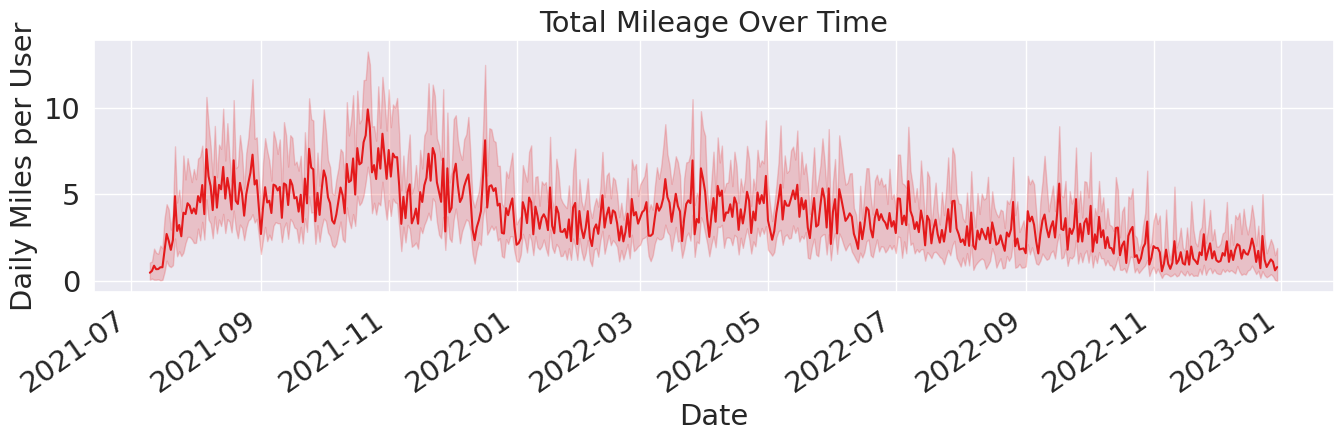

In [306]:
# How total mileage changes over time
plot_data = data.copy()
plot_data ['date_time'] = pd.to_datetime(plot_data['date_time'])

#need to count all combinations - make sure to treat as categorical
plot_data["User"] = plot_data["user_id"].astype("category")
plot_data["Date"] = plot_data["date_time"].astype("category")
plot_data = plot_data.groupby(['User', 'Date']).distance_miles.sum().reset_index()

plot_data

plot_title = 'Total Mileage Over Time'
ylab = 'Daily Miles per User'
file_name = "CanBikeCO_report_ts_miles"
fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(data=test, x='Date', y='distance_miles', estimator=np.mean).set(title=plot_title, xlabel='Date', ylabel=ylab)
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(file_name+".png", bbox_inches='tight')

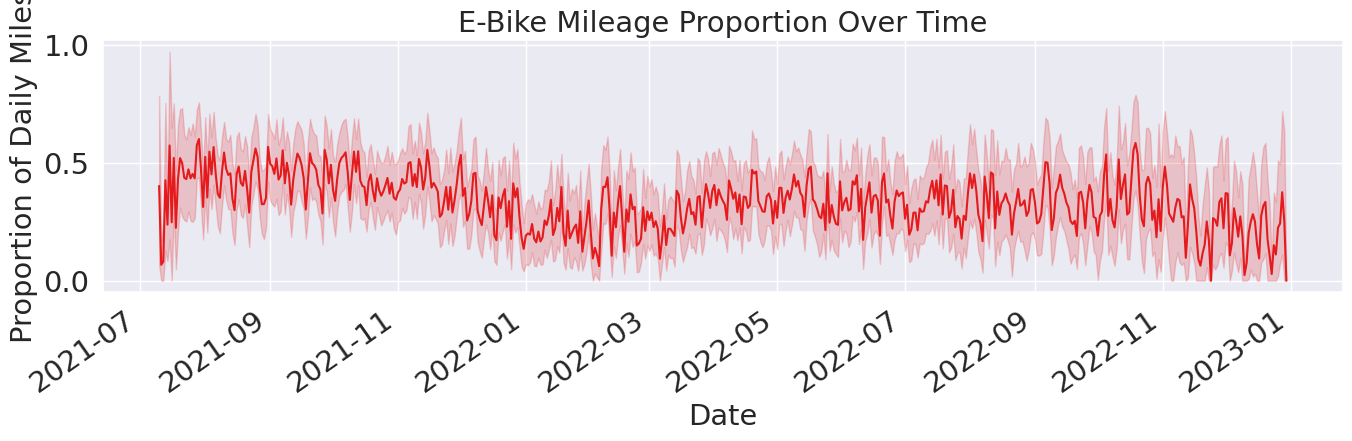

In [307]:
# How ebike mileage changes over time
plot_data = data.copy()
plot_data['date_time'] = pd.to_datetime(plot_data['date_time'])

#treat as categorical to count all combinations
plot_data["user_id"] = plot_data["user_id"].astype("category")
plot_data["date_time"] = plot_data["date_time"].astype("category")
plot_data['Mode_confirm'] = plot_data['Mode_confirm'].astype("category")

#using the total mileage data as one side
t1 = plot_data.groupby(['user_id', 'date_time']).distance_miles.sum().reset_index()

#create the other side -- also grouping by mode
t2 = plot_data.groupby(['user_id', 'date_time', 'Mode_confirm']).distance_miles.sum().reset_index()

t2.sample(n=50, random_state=321)

#then we merge
plot_data = t2.merge(t1, on=['user_id','date_time'])
plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data.sample(n=50, random_state=321)

plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)

plot_data.sample(n=50, random_state=321)

plot_data = plot_data[plot_data['distance_miles_y'].notnull()]
plot_data = plot_data[plot_data['distance_miles_y'] != 0] #drop 0 mile days to prevent 0/0 reading as 1

plot_title = 'E-Bike Mileage Proportion Over Time'
ylab = 'Proportion of Daily Miles'
file_name = "CanBikeCO_report_ts_mileage_proportion"
fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(data=plot_data, x='date_time', y='proportion', estimator=np.mean).set(title=plot_title, xlabel='Date', ylabel=ylab)
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(file_name+".png", bbox_inches='tight')

## Distance and mode!

figure #16 & 17

In [308]:
sns.set_palette('Set1', 9)

<Axes: xlabel='distance_miles', ylabel='Count'>

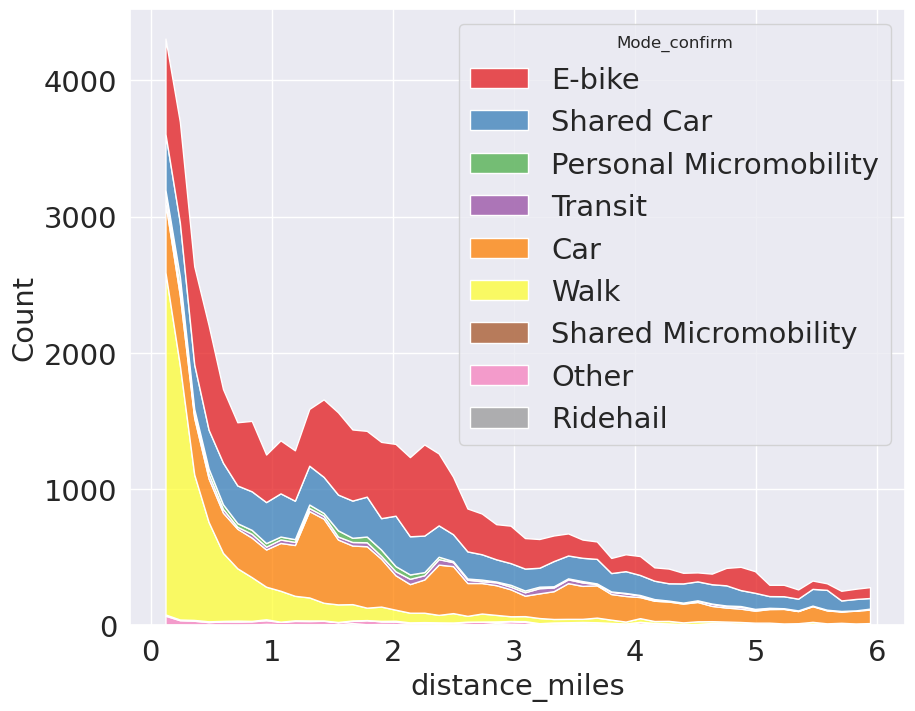

In [309]:
# Distance and mode chosen relationship -- short trips
plot_data = data.copy()
plot_data = plot_data[plot_data['distance_miles']<6]

plot_title = 'Mode Share by Trip Distance'
ylab = 'Total Trips'
file_name = "CanBikeCO_report_mode_share_distance_short"
sns.histplot(plot_data, x="distance_miles", hue="Mode_confirm", element="poly", multiple="stack")
# proportion_hist_plot(plot_data, 'distance_miles', plot_title, ylab, file_name)

<Axes: xlabel='distance_miles', ylabel='Count'>

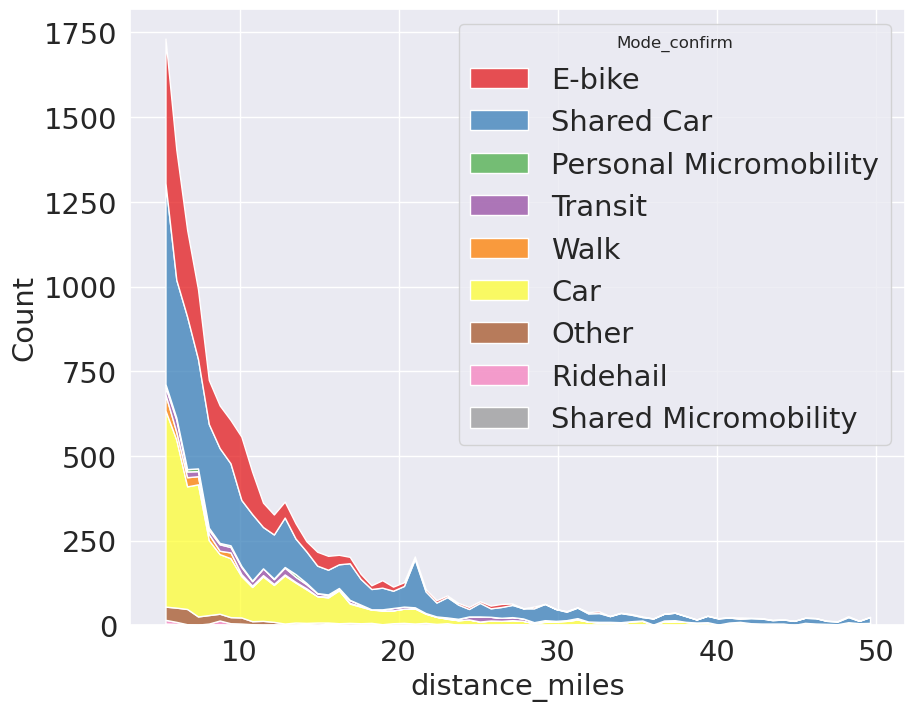

In [310]:
# Distance and mode chosen relationship -- long trips
plot_data = data.copy()
plot_data = plot_data[plot_data['distance_miles']>5]

plot_title = 'Mode Share by Trip Distance'
ylab = 'Total Trips'
file_name = "CanBikeCO_report_mode_share_distance_long"
# proportion_hist_plot(plot_data, 'distance_miles', plot_title, ylab, file_name)
sns.histplot(plot_data, x="distance_miles", hue="Mode_confirm", element="poly", multiple="stack")

## induced trip purposes for e-bikes

Figure #24

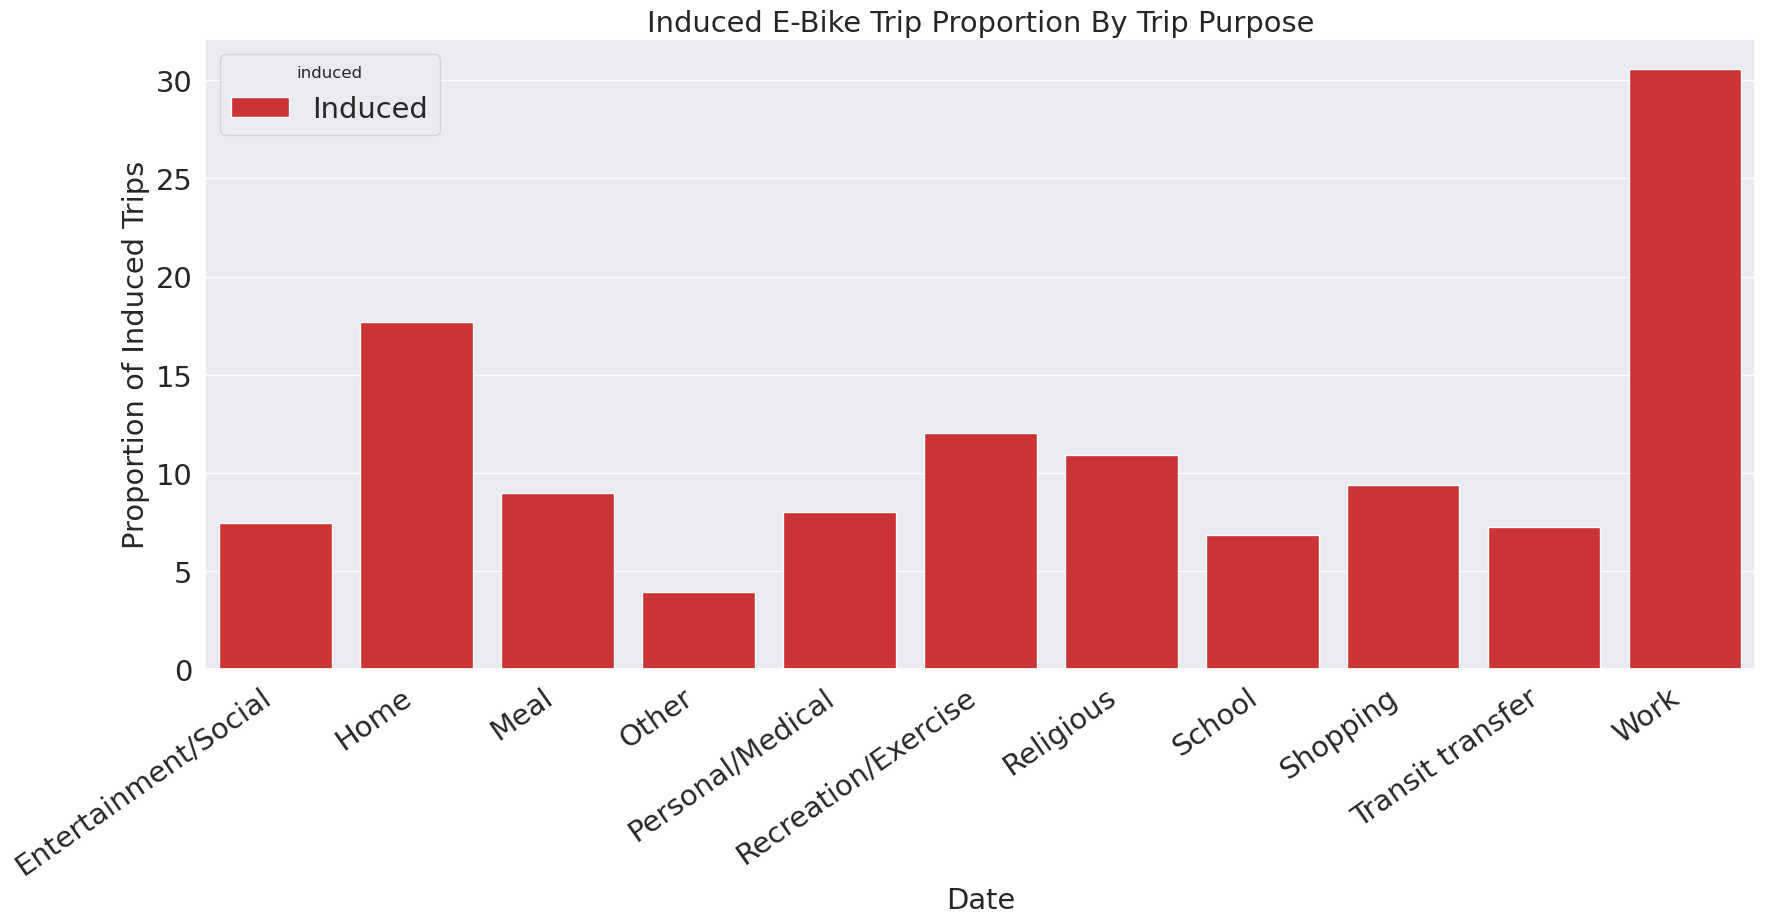

In [311]:
# What purpose ebike is used for by program
plot_data = data.copy()
t1 = plot_data.groupby(['induced','Trip_purpose','Mode_confirm'], as_index=False).count()[['induced','Trip_purpose','Mode_confirm','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.groupby(['induced','Trip_purpose'], as_index=False).count()[['induced','Trip_purpose','distance_miles']]
plot_data = t1.merge(t2, on=['induced','Trip_purpose'])
plot_data['proportion'] = (plot_data['distance_miles_x'] / plot_data['distance_miles_y'])*100
plot_data['proportion'].fillna(0, inplace=True)
plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data = plot_data[plot_data['induced']=='Induced']

plot_title = 'Induced E-Bike Trip Proportion By Trip Purpose'
ylab = 'Proportion of Induced Trips'
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=plot_data, x='Trip_purpose', y='proportion', hue='induced',estimator=np.mean, ci=None).set(title=plot_title, xlabel='Date', ylabel=ylab)
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
